In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import corner
import plotly
import plotly.graph_objects as go

# Data investigation

Extention of computations and plots from 'data-correlation-investigation' focusing on storing results to disk to allow easy plotting and avoid repeated running

In [2]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

# Data loading

In [3]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [4]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

In [5]:
# Setup 3 datasets: "outlier", "counts", "concentrations"

# "outlier": outlying cell present
data_outlier = data_FIB.copy(deep=True)

# "counts": outlying cell removed (default)
data_counts = data_FIB.copy(deep=True)
data_counts = data_counts.drop(labels=['Fibroblasts_P23_S383'], axis=1)

# "concentrations": total cell count normalized counts (outlying cell removed)
data_concentrations = data_counts.copy(deep=True)
cell_totals = data_concentrations.sum(axis=0)
data_concentrations = data_concentrations / cell_totals

In [6]:
# Estimate capture
beta_outlier = estimate_capture(data_outlier)
beta_counts = estimate_capture(data_counts)

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


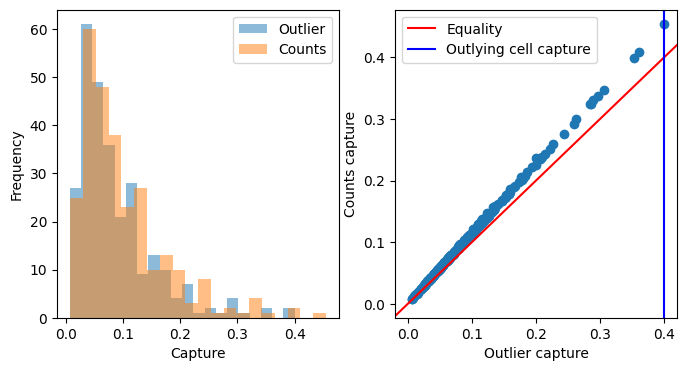

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(beta_outlier, alpha=0.5, bins=20, label="Outlier")
axs[0].hist(beta_counts, alpha=0.5, bins=20, label="Counts")
axs[0].set_xlabel("Capture")
axs[0].set_ylabel("Frequency")
axs[0].legend()
idx_outlier = data_outlier.columns.tolist().index('Fibroblasts_P23_S383')
axs[1].scatter(np.delete(beta_outlier, idx_outlier), beta_counts)
axs[1].axline([0, 0], [0.1, 0.1], color="red", label="Equality")
axs[1].axvline(beta_outlier[idx_outlier], color="blue", label="Outlying cell capture")
axs[1].set_xlabel("Outlier capture")
axs[1].set_ylabel("Counts capture")
axs[1].legend()
plt.show()

In [8]:
# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of protein coding (~mRNA) and non-coding miRNA
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# separate data

# outlier
data_outlier_pcRNA = data_outlier.iloc[pcRNA_indices]
data_outlier_miRNA = data_outlier.iloc[miRNA_indices]

# counts
data_counts_pcRNA = data_counts.iloc[pcRNA_indices]
data_counts_miRNA = data_counts.iloc[miRNA_indices]

# concentrations
data_concentrations_pcRNA = data_concentrations.iloc[pcRNA_indices]
data_concentrations_miRNA = data_concentrations.iloc[miRNA_indices]

# amounts
print(f"Total of {data_counts.shape[0]} genes with mean > 1 present \nSelected {data_counts_miRNA.shape[0]} non-coding miRNA \nSelected {data_counts_pcRNA.shape[0]} protein coding (mRNA)")

Total of 11901 genes with mean > 1 present 
Selected 18 non-coding miRNA 
Selected 9376 protein coding (mRNA)


# Correlation tests

In [9]:
def direct_correlation_bootstrap_sample(x1_sample, x2_sample, confidence=None, resamples=None):

    # get sample size
    n = len(x1_sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n
    # confidence level: default to 95%
    if confidence is None:
        confidence = 0.95

    # initialize random generator
    rng = np.random.default_rng()

    # separate sample pairs
    x1_sample = list(x1_sample)
    x2_sample = list(x2_sample)

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # compute correlations
    estimates = np.zeros(resamples)
    for i in range(resamples):

        b1 = boot[i, :, 0]
        b2 = boot[i, :, 1]

        E_xy = np.mean(b1 * b2)
        E_x = np.mean(b1)
        E_y = np.mean(b2)
        E_x2 = np.mean(b1**2)
        E_y2 = np.mean(b2**2)

        sigx = np.sqrt(E_x2 - E_x**2)
        sigy = np.sqrt(E_y2 - E_y**2)

        if sigx == 0.0 or sigy == 0.0:
            corr = np.nan
        else:
            corr = (E_xy - E_x*E_y) / (sigx * sigy)

        # test = scipy.stats.pearsonr(boot[i, :, 0], boot[i, :, 1])
        estimates[i] = corr #test.statistic

    # take quantiles
    alpha = 1 - confidence
    interval = np.quantile(estimates, [(alpha / 2), 1 - (alpha / 2)])

    return interval

In [69]:
def direct_correlation_bootstrap_dataset(mirna_sample, mrna_dataset, confidence=None, resamples=None):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # record bounds
    bounds = np.empty((gene_pairs, 2))
    
    # bootstrap
    for i in tqdm.tqdm(range(gene_pairs)):
        bounds[i, :] = direct_correlation_bootstrap_sample(mirna_sample, mrna_dataset.iloc[i], confidence, resamples)

    return bounds

In [111]:
# selected miRNA
miRNA = "MIR100"

In [ ]:
# dataframe to store correlation results
#correlation_df = pd.DataFrame(
#    index=data_counts_pcRNA.index
#)

## Running

### Outlier

In [ ]:
# construct dataset of miRNA paired with all mRNA
dataset_outlier = construct_dataset(data_outlier_miRNA.loc[miRNA], data_outlier_pcRNA, beta_outlier)

# run correlation test: 1-sided & 2-sided
correlations_outlier_1 = Correlation(dataset_outlier, printing=False, alternative="less")
correlations_outlier_2 = Correlation(dataset_outlier, printing=False, alternative="two-sided")

In [ ]:
# compute direct bootstrap bounds
correlation_outlier_bounds = direct_correlation_bootstrap_dataset(data_outlier_miRNA.loc[miRNA], data_outlier_pcRNA)

In [215]:
# extract results (rho same for 1 or 2 sided test)
rho = [res['statistic'] for res in correlations_outlier_1.result_dict.values()]
p1 = [res['pvalue'] for res in correlations_outlier_1.result_dict.values()]
p2 = [res['pvalue'] for res in correlations_outlier_2.result_dict.values()]
lb = correlation_outlier_bounds[:, 0]
ub = correlation_outlier_bounds[:, 1]

# store on dataframe
correlation_df['outlier_rho'] = rho
correlation_df['outlier_p1'] = p1
correlation_df['outlier_p2'] = p2
correlation_df['outlier_lb'] = lb
correlation_df['outlier_ub'] = ub

### Counts

In [ ]:
# construct dataset of miRNA paired with all mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA, beta_counts)

# run correlation test: 1-sided & 2-sided
correlations_counts_1 = Correlation(dataset_counts, printing=False, alternative="less")
correlations_counts_2 = Correlation(dataset_counts, printing=False, alternative="two-sided")

In [473]:
# compute direct bootstrap bounds
correlation_counts_bounds_c95 = direct_correlation_bootstrap_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA, confidence=0.95)

100%|██████████| 9376/9376 [01:58<00:00, 79.13it/s]


In [474]:
correlation_counts_bounds_c50 = direct_correlation_bootstrap_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA, confidence=0.50)

100%|██████████| 9376/9376 [01:54<00:00, 81.73it/s]


In [475]:
correlation_counts_bounds_c25 = direct_correlation_bootstrap_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA, confidence=0.25)

100%|██████████| 9376/9376 [01:58<00:00, 78.86it/s]


In [ ]:
# extract results (rho same for 1 or 2 sided test)
rho = [res['statistic'] for res in correlations_counts_1.result_dict.values()]
p1 = [res['pvalue'] for res in correlations_counts_1.result_dict.values()]
p2 = [res['pvalue'] for res in correlations_counts_2.result_dict.values()]

# store on dataframe
correlation_df['counts_rho'] = rho
correlation_df['counts_p1'] = p1
correlation_df['counts_p2'] = p2

In [476]:
# store on dataframe
correlation_df['counts_c95_lb'] = correlation_counts_bounds_c95[:, 0]
correlation_df['counts_c95_ub'] = correlation_counts_bounds_c95[:, 1]
correlation_df['counts_c50_lb'] = correlation_counts_bounds_c50[:, 0]
correlation_df['counts_c50_ub'] = correlation_counts_bounds_c50[:, 1]
correlation_df['counts_c25_lb'] = correlation_counts_bounds_c25[:, 0]
correlation_df['counts_c25_ub'] = correlation_counts_bounds_c25[:, 1]

### Concentration

In [ ]:
# construct dataset of miRNA paired with all mRNA
dataset_concentrations = construct_dataset(data_concentrations_miRNA.loc[miRNA], data_concentrations_pcRNA, None)

# run correlation test: 1-sided & 2-sided
correlations_concentrations_1 = Correlation(dataset_concentrations, printing=False, alternative="less")
correlations_concentrations_2 = Correlation(dataset_concentrations, printing=False, alternative="two-sided")

In [ ]:
# compute direct bootstrap bounds
correlation_concentrations_bounds = direct_correlation_bootstrap_dataset(data_concentrations_miRNA.loc[miRNA], data_concentrations_pcRNA)

In [217]:
# extract results (rho same for 1 or 2 sided test)
rho = [res['statistic'] for res in correlations_concentrations_1.result_dict.values()]
p1 = [res['pvalue'] for res in correlations_concentrations_1.result_dict.values()]
p2 = [res['pvalue'] for res in correlations_concentrations_2.result_dict.values()]
lb = correlation_concentrations_bounds[:, 0]
ub = correlation_concentrations_bounds[:, 1]

# store on dataframe
correlation_df['concentrations_rho'] = rho
correlation_df['concentrations_p1'] = p1
correlation_df['concentrations_p2'] = p2
correlation_df['concentrations_lb'] = lb
correlation_df['concentrations_ub'] = ub

### Save & Load

In [ ]:
# save
# correlation_df.to_csv("Results/correlations.csv")

In [11]:
# load
correlation_df = pd.read_csv("Results/correlations.csv", index_col=0)

# Model Free Independence Test

In [494]:
def model_free_independence_test(dataset, d, confidence):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=False)

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF_ind.analyse_dataset()

    # extract feasibility
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    return status

In [495]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 1000
mRNA = data_counts_pcRNA.index[:genes]

In [ ]:
# dataframe to store model free results
#MF_ind_df = pd.DataFrame(
#    index=mRNA
#)

## Running

### Outlier

In [497]:
# construct dataset of miRNA paired with mRNA
dataset_outlier = construct_dataset(data_outlier_miRNA.loc[miRNA], data_outlier_pcRNA.loc[mRNA], beta_outlier)

In [ ]:
MF_ind_outlier_feasibility_d2_c95 = model_free_independence_test(dataset_outlier, 2, 0.95)

In [ ]:
MF_ind_outlier_feasibility_d3_c95 = model_free_independence_test(dataset_outlier, 3, 0.95)

In [ ]:
MF_ind_outlier_feasibility_d4_c95 = model_free_independence_test(dataset_outlier, 4, 0.95)

In [136]:
# store on dataframe
MF_ind_df['outlier_d2_c95'] = MF_ind_outlier_feasibility_d2_c95
MF_ind_df['outlier_d3_c95'] = MF_ind_outlier_feasibility_d3_c95
MF_ind_df['outlier_d4_c95'] = MF_ind_outlier_feasibility_d4_c95

### Counts

In [498]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [ ]:
MF_ind_counts_feasibility_d2_c95 = model_free_independence_test(dataset_counts, 2, 0.95)

In [ ]:
MF_ind_counts_feasibility_d3_c95 = model_free_independence_test(dataset_counts, 3, 0.95)

In [ ]:
MF_ind_counts_feasibility_d4_c95 = model_free_independence_test(dataset_counts, 4, 0.95)

In [499]:
MF_ind_counts_feasibility_d4_c50 = model_free_independence_test(dataset_counts, 4, 0.50)

100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


In [500]:
MF_ind_counts_feasibility_d4_c25 = model_free_independence_test(dataset_counts, 4, 0.25)

100%|██████████| 1000/1000 [00:53<00:00, 18.60it/s]


In [129]:
# store on dataframe
MF_ind_df['counts_d2_c95'] = MF_ind_counts_feasibility_d2_c95
MF_ind_df['counts_d3_c95'] = MF_ind_counts_feasibility_d3_c95
MF_ind_df['counts_d4_c95'] = MF_ind_counts_feasibility_d4_c95

In [505]:
MF_ind_df['counts_d4_c50'] = MF_ind_counts_feasibility_d4_c50
MF_ind_df['counts_d4_c25'] = MF_ind_counts_feasibility_d4_c25

### Save & Load

In [ ]:
# save
# MF_ind_df.to_csv("Results/independent_MF.csv")

In [12]:
# load
MF_ind_df = pd.read_csv("Results/independent_MF.csv", index_col=0)

# Interacting Model-Free Test

In [ ]:
def interacting_model_free_test(dataset, d, confidence):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=False)

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF_ind.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]


    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_MF_ind.result_dict.values()]

    # collect
    data = {
        'status': status,
        'correlation': correlation
    }

    return data

In [293]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 1000
mRNA = data_counts_pcRNA.index[:genes]

In [ ]:
# dataframe to store model free results
#MF_int_df = pd.DataFrame(
#    index=mRNA
#)

## Running

### Counts

In [296]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [299]:
MF_int_counts_d4_c95 = interacting_model_free_test(dataset_counts, 4, 0.95)

100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


In [312]:
MF_int_counts_d4_c50 = interacting_model_free_test(dataset_counts, 4, 0.50)

100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s]


In [315]:
MF_int_counts_d4_c25 = interacting_model_free_test(dataset_counts, 4, 0.25)

100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


In [316]:
# store on dataframe
MF_int_df['counts_d4_c95_status'] = MF_int_counts_d4_c95['status']
MF_int_df['counts_d4_c95_correlation'] = MF_int_counts_d4_c95['correlation']
MF_int_df['counts_d4_c50_status'] = MF_int_counts_d4_c50['status']
MF_int_df['counts_d4_c50_correlation'] = MF_int_counts_d4_c50['correlation']
MF_int_df['counts_d4_c25_status'] = MF_int_counts_d4_c25['status']
MF_int_df['counts_d4_c25_correlation'] = MF_int_counts_d4_c25['correlation']

### Save & Load

In [ ]:
# save
# MF_int_df.to_csv("Results/interacting_MF.csv")

In [13]:
# load
MF_int_df = pd.read_csv("Results/interacting_MF.csv", index_col=0)

# Interacting Birth-Death Test

In [142]:
def interacting_birth_death_test(dataset, d, confidence, fixed=[(3, 1)], K=100, bootstrap=True):

    # bootstrap
    if bootstrap:
        dataset.confidence = confidence
        dataset.bootstrap(d, tqdm_disable=False)

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed, K=K)
    opt_BD.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_BD.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_BD.result_dict.values()]

    # collect
    data = {
        'status': status,
        'correlation': correlation
    }

    return data

In [144]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 100 # 1000
mRNA = data_counts_pcRNA.index[:genes]

In [145]:
# dataframe to store birth death results
BD_int_df = pd.DataFrame(
    index=mRNA
)

## Running

### Counts

In [28]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [29]:
BD_int_counts_d3_c95 = interacting_birth_death_test(dataset_counts, 3, 0.95, K=None)

100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


In [30]:
BD_int_counts_d3_c50 = interacting_birth_death_test(dataset_counts, 3, 0.50, K=None)

100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


In [ ]:
# very slow for K = None
BD_int_counts_d4_c95 = interacting_birth_death_test(dataset_counts, 4, 0.95, K=None)

 50%|█████     | 50/100 [8:21:49<8:21:49, 602.19s/it]  


KeyboardInterrupt: 

In [ ]:
# store on dataframe
#BD_int_df['counts_d3_c95_status'] = BD_int_counts_d3_c95['status']
#BD_int_df['counts_d3_c95_correlation'] = BD_int_counts_d3_c95['correlation']
#BD_int_df['counts_d3_c50_status'] = BD_int_counts_d3_c50['status']
#BD_int_df['counts_d3_c50_correlation'] = BD_int_counts_d3_c50['correlation']
#BD_int_df['counts_d4_c95_status'] = BD_int_counts_d4_c95['status']
#BD_int_df['counts_d4_c95_correlation'] = BD_int_counts_d4_c95['correlation']

### Fixed k_reg = 1

In [101]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [102]:
BD_int_counts_d3_c95_reg = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(4, 1)], K=None)

100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


In [103]:
BD_int_counts_d3_c50_reg = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(4, 1)], K=None)

100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


In [ ]:
# store on dataframe
#BD_int_df['counts_d3_c95_reg_status'] = BD_int_counts_d3_c95_reg['status']
#BD_int_df['counts_d3_c95_reg_correlation'] = BD_int_counts_d3_c95_reg['correlation']
#BD_int_df['counts_d3_c50_reg_status'] = BD_int_counts_d3_c50_reg['status']
#BD_int_df['counts_d3_c50_reg_correlation'] = BD_int_counts_d3_c50_reg['correlation']

### Save & Load

In [ ]:
# save
#BD_int_df.to_csv("Results/KNone/interacting_BD.csv")

In [ ]:
# load
#BD_int_df = pd.read_csv("Results/interacting_BD.csv", index_col=0)

### Comparison: K = 100 vs K = None

In [147]:
# dataframe to store results
BD_int_comparison_df = pd.DataFrame(
    index=mRNA
)

In [148]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [151]:
# bootstrap
dataset_counts.confidence = 0.95
dataset_counts.bootstrap(3, tqdm_disable=False)

100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


In [159]:
BD_int_counts_d3_c95_K100 = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(3, 1)], K=100, bootstrap=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


In [160]:
BD_int_counts_d3_c95_reg_K100 = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(4, 1)], K=100, bootstrap=False)

100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


In [161]:
BD_int_counts_d3_c95_tx_K100 = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(0, 1)], K=100, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


In [162]:
BD_int_counts_d3_c95_KNone = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(3, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


In [163]:
BD_int_counts_d3_c95_reg_KNone = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(4, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


In [164]:
BD_int_counts_d3_c95_tx_KNone = interacting_birth_death_test(dataset_counts, 3, 0.95, fixed=[(0, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


In [165]:
# store on dataframe
BD_int_comparison_df['counts_d3_c95_K100_status'] = BD_int_counts_d3_c95_K100['status']
BD_int_comparison_df['counts_d3_c95_K100_correlation'] = BD_int_counts_d3_c95_K100['correlation']
BD_int_comparison_df['counts_d3_c95_reg_K100_status'] = BD_int_counts_d3_c95_reg_K100['status']
BD_int_comparison_df['counts_d3_c95_reg_K100_correlation'] = BD_int_counts_d3_c95_reg_K100['correlation']
BD_int_comparison_df['counts_d3_c95_tx_K100_status'] = BD_int_counts_d3_c95_tx_K100['status']
BD_int_comparison_df['counts_d3_c95_tx_K100_correlation'] = BD_int_counts_d3_c95_tx_K100['correlation']

BD_int_comparison_df['counts_d3_c95_KNone_status'] = BD_int_counts_d3_c95_KNone['status']
BD_int_comparison_df['counts_d3_c95_KNone_correlation'] = BD_int_counts_d3_c95_KNone['correlation']
BD_int_comparison_df['counts_d3_c95_reg_KNone_status'] = BD_int_counts_d3_c95_reg_KNone['status']
BD_int_comparison_df['counts_d3_c95_reg_KNone_correlation'] = BD_int_counts_d3_c95_reg_KNone['correlation']
BD_int_comparison_df['counts_d3_c95_tx_KNone_status'] = BD_int_counts_d3_c95_tx_KNone['status']
BD_int_comparison_df['counts_d3_c95_tx_KNone_correlation'] = BD_int_counts_d3_c95_tx_KNone['correlation']

In [166]:
# bootstrap
dataset_counts.confidence = 0.50
dataset_counts.bootstrap(3, tqdm_disable=False)

100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


In [167]:
BD_int_counts_d3_c50_K100 = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(3, 1)], K=100, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


In [168]:
BD_int_counts_d3_c50_reg_K100 = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(4, 1)], K=100, bootstrap=False)

100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


In [169]:
BD_int_counts_d3_c50_tx_K100 = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(0, 1)], K=100, bootstrap=False)

100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


In [170]:
BD_int_counts_d3_c50_KNone = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(3, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [05:08<00:00,  3.08s/it]


In [171]:
BD_int_counts_d3_c50_reg_KNone = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(4, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


In [172]:
BD_int_counts_d3_c50_tx_KNone = interacting_birth_death_test(dataset_counts, 3, 0.50, fixed=[(0, 1)], K=None, bootstrap=False)

100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


In [173]:
# store on dataframe
BD_int_comparison_df['counts_d3_c50_K100_status'] = BD_int_counts_d3_c50_K100['status']
BD_int_comparison_df['counts_d3_c50_K100_correlation'] = BD_int_counts_d3_c50_K100['correlation']
BD_int_comparison_df['counts_d3_c50_reg_K100_status'] = BD_int_counts_d3_c50_reg_K100['status']
BD_int_comparison_df['counts_d3_c50_reg_K100_correlation'] = BD_int_counts_d3_c50_reg_K100['correlation']
BD_int_comparison_df['counts_d3_c50_tx_K100_status'] = BD_int_counts_d3_c50_tx_K100['status']
BD_int_comparison_df['counts_d3_c50_tx_K100_correlation'] = BD_int_counts_d3_c50_tx_K100['correlation']

BD_int_comparison_df['counts_d3_c50_KNone_status'] = BD_int_counts_d3_c50_KNone['status']
BD_int_comparison_df['counts_d3_c50_KNone_correlation'] = BD_int_counts_d3_c50_KNone['correlation']
BD_int_comparison_df['counts_d3_c50_reg_KNone_status'] = BD_int_counts_d3_c50_reg_KNone['status']
BD_int_comparison_df['counts_d3_c50_reg_KNone_correlation'] = BD_int_counts_d3_c50_reg_KNone['correlation']
BD_int_comparison_df['counts_d3_c50_tx_KNone_status'] = BD_int_counts_d3_c50_tx_KNone['status']
BD_int_comparison_df['counts_d3_c50_tx_KNone_correlation'] = BD_int_counts_d3_c50_tx_KNone['correlation']

In [175]:
# save
BD_int_comparison_df.to_csv("Results/KComparison/interacting_BD.csv")

# Interacting Telegraph Test

In [35]:
def interacting_telegraph_test(dataset, d, confidence, fixed=[(7, 1)], K=100):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=False)

    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed, K=K)
    opt_TE.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_TE.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_TE.result_dict.values()]

    # collect
    data = {
        'status': status,
        'correlation': correlation
    }

    return data

In [36]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 100 # 1000
mRNA = data_counts_pcRNA.index[:genes]

In [37]:
# dataframe to store telegraph results
TE_int_df = pd.DataFrame(
    index=mRNA
)

## Running

### Counts

In [38]:
# construct dataset of miRNA paired with mRNA
dataset_counts = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [39]:
TE_int_counts_d3_c95 = interacting_telegraph_test(dataset_counts, 3, 0.95, K=None)

100%|██████████| 100/100 [19:54<00:00, 11.94s/it]


In [41]:
TE_int_counts_d3_c50 = interacting_telegraph_test(dataset_counts, 3, 0.50, K=None)

100%|██████████| 100/100 [34:27<00:00, 20.68s/it] 


In [ ]:
# store on dataframe
#TE_int_df['counts_d3_c95_status'] = TE_int_counts_d3_c95['status']
#TE_int_df['counts_d3_c95_correlation'] = TE_int_counts_d3_c95['correlation']
#TE_int_df['counts_d3_c50_status'] = TE_int_counts_d3_c50['status']
#TE_int_df['counts_d3_c50_correlation'] = TE_int_counts_d3_c50['correlation']

### Save & Load

In [ ]:
# save
#TE_int_df.to_csv("Results/KNone/interacting_TE.csv")

In [ ]:
# load
#TE_int_df = pd.read_csv("Results/interacting_TE.csv", index_col=0)

# Result loading

In [44]:
correlation_df = pd.read_csv("Results/correlations.csv", index_col=0)
MF_ind_df = pd.read_csv("Results/independent_MF.csv", index_col=0)
MF_int_df = pd.read_csv("Results/interacting_MF.csv", index_col=0)

In [107]:
BD_int_KNone_df = pd.read_csv("Results/KNone/interacting_BD.csv", index_col=0)
TE_int_KNone_df = pd.read_csv("Results/KNone/interacting_TE.csv", index_col=0)

In [108]:
BD_int_K100_df = pd.read_csv("Results/K100/interacting_BD.csv", index_col=0)
TE_int_K100_df = pd.read_csv("Results/K100/interacting_TE.csv", index_col=0)

# Plots

In [46]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Gene pairs"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text="Basic Sankey Diagram", 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

## Observed correlation corner plot

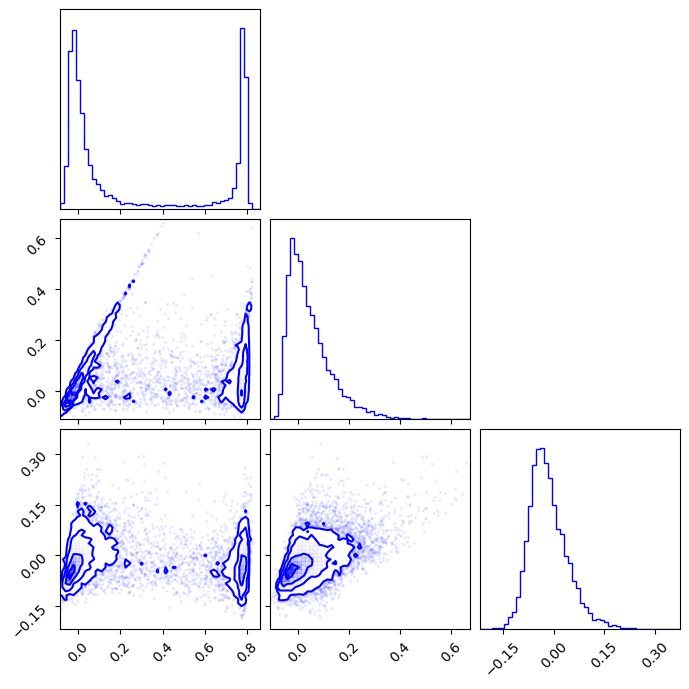

In [286]:
corner.corner(
    correlation_df[['outlier_rho', 'counts_rho', 'concentrations_rho']],
    bins=50,
    color="blue"
)
plt.show()

## Correlation tests

In [ ]:
def plot_correlation_test(axs, data, side, bins_sig, bins_nonsig):

    # separate (in)significant samples
    sig_mask = correlation_df[f'{data}_p{side}'] < 0.05

    # select rho for the 2 classes
    sig_rho = correlation_df[sig_mask][f'{data}_rho']
    nonsig_rho = correlation_df[-sig_mask][f'{data}_rho']

    # sizes
    num_sig = len(sig_rho)
    num_nonsig = len(nonsig_rho)
    n = num_sig + num_nonsig

    # plot
    axs.hist(sig_rho, color="red", bins=bins_sig, label=f"Sig. ({num_sig})")
    axs.hist(nonsig_rho, color="green", bins=bins_nonsig, label=f"Non-Sig. ({num_nonsig})")
    axs.legend()

Text(0.5, 0.98, 'Correlation tests')

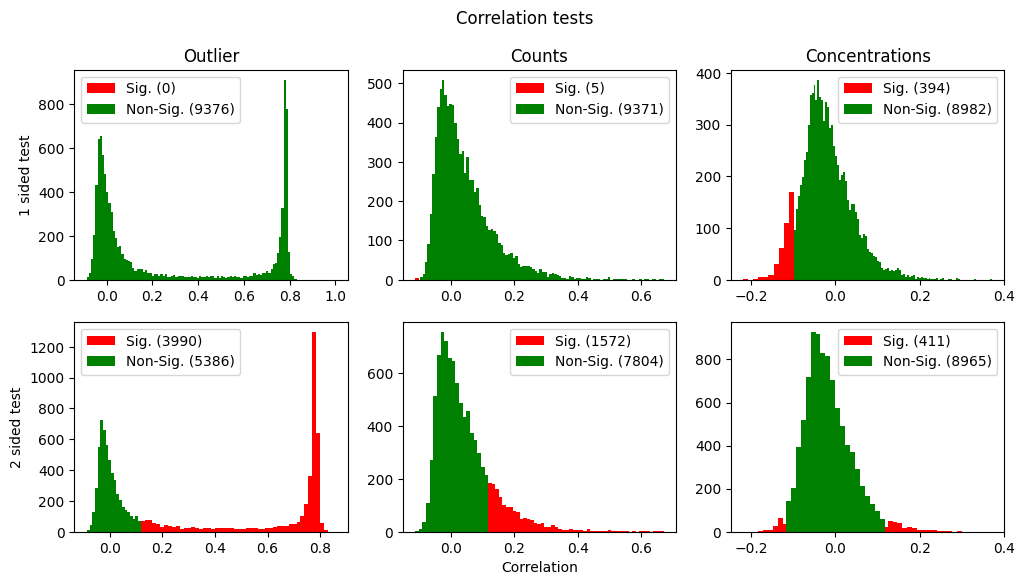

In [285]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

plot_correlation_test(axs[0, 0], "outlier", 1, 1, 100)
plot_correlation_test(axs[1, 0], "outlier", 2, 50, 20)
plot_correlation_test(axs[0, 1], "counts", 1, 1, 100)
plot_correlation_test(axs[1, 1], "counts", 2, 50, 20)
plot_correlation_test(axs[0, 2], "concentrations", 1, 10, 100)
plot_correlation_test(axs[1, 2], "concentrations", 2, 50, 20)

axs[0, 0].set_ylabel("1 sided test")
axs[1, 0].set_ylabel("2 sided test")

axs[0, 0].set_title("Outlier")
axs[0, 1].set_title("Counts")
axs[0, 2].set_title("Concentrations")

axs[1, 1].set_xlabel("Correlation")

plt.suptitle("Correlation tests")

## Independent Model Free Test

### Feasibility

In [ ]:
# plot histograms like in presentation

### Order d effect

In [ ]:
# plot sankey like previously

### Outlier removal effect

How do results change

In [292]:
sankey_from_df(MF_ind_df[['outlier_d2_c95', 'counts_d2_c95']])
sankey_from_df(MF_ind_df[['outlier_d3_c95', 'counts_d3_c95']])
sankey_from_df(MF_ind_df[['outlier_d4_c95', 'counts_d4_c95']])

## Interacting Model Free Test

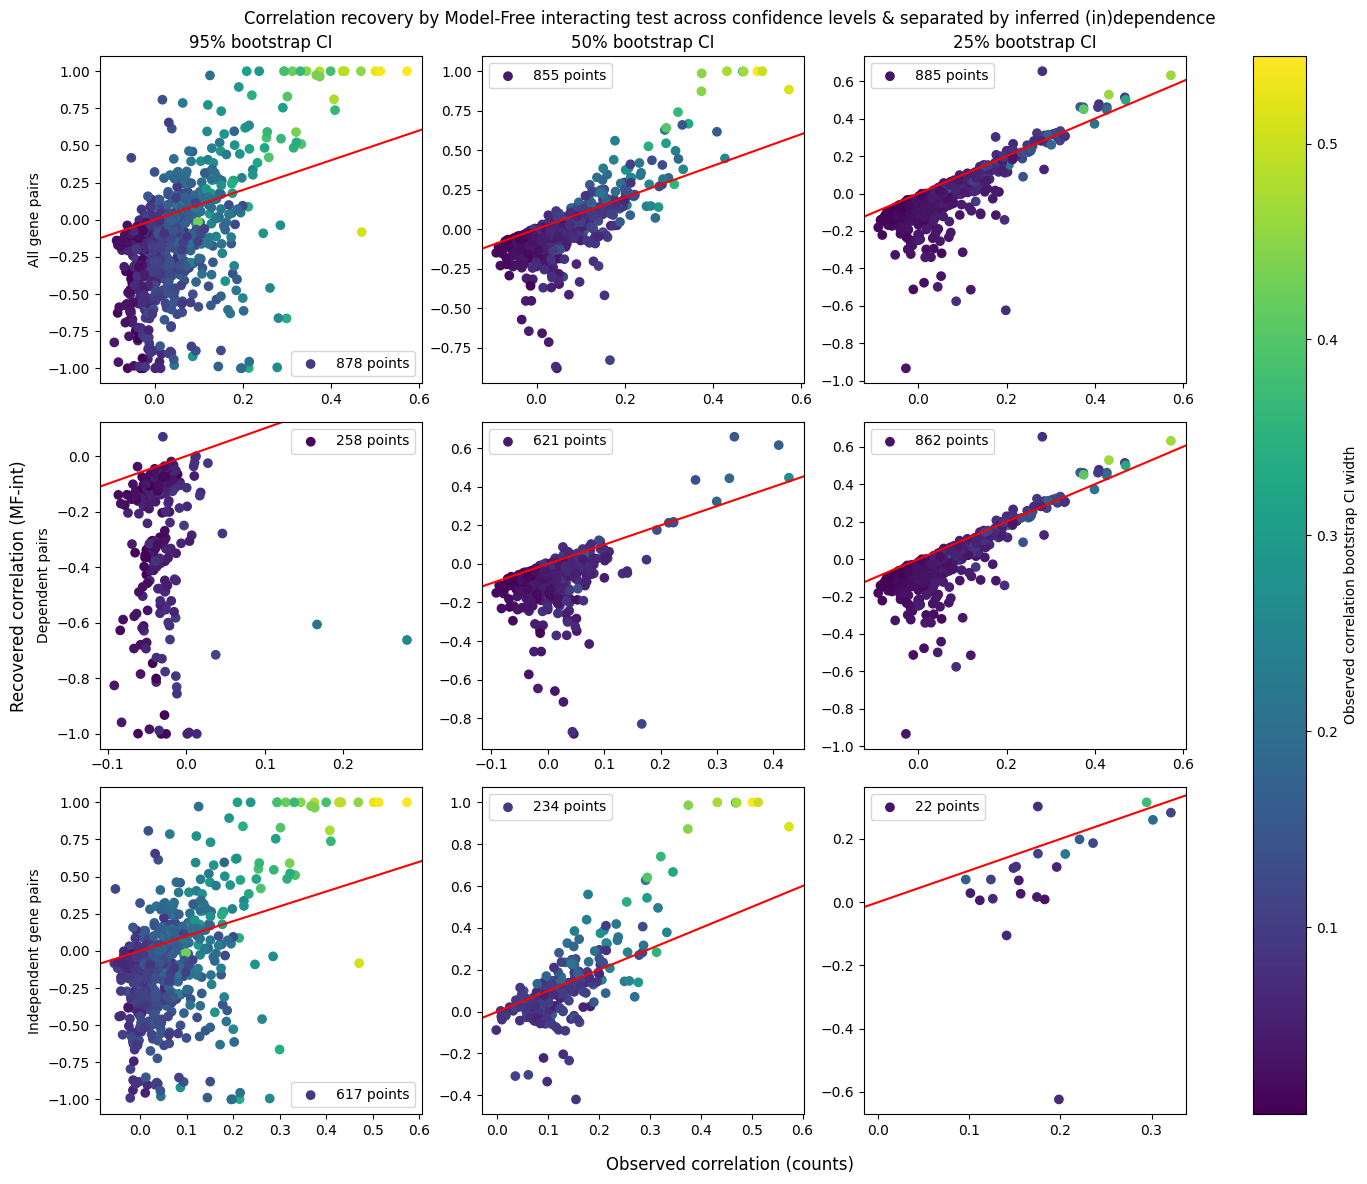

In [524]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

obs_corr = correlation_df['counts_rho'].iloc[:1000]

for j, confidence in enumerate([95, 50, 25]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = MF_int_df[f'counts_d4_c{confidence}_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:1000]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (MF-int)")
fig.suptitle("Correlation recovery by Model-Free interacting test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")
axs[0, 2].set_title("25% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

- Number of points don't add up (1st row = 2nd + 3rd) because 1st row plots MF-ind OPTIMAL & INFEASIBLE & other: TIME_LIMIT, CUT_LIMIT which are feasible and so give a correlation under MF-int
- colorbar shared across all plots, but not so informative as many small values

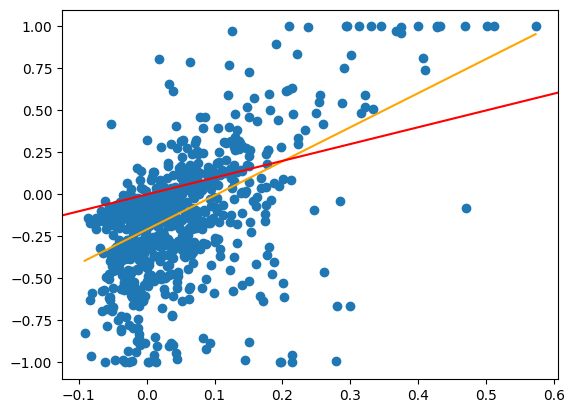

In [ ]:
x = correlation_df['counts_rho'].iloc[:1000]
y = MF_int_df['counts_d4_c95_correlation']
na_mask = -y.isna()
x = x[na_mask]
y = y[na_mask]
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange")
plt.axline([0, 0], [0.1, 0.1], color="red")
plt.show()

Try fit a line to recovered correlations
- not so informative

Try plot against concentration correlations
- have smaller range, don't see any clear / interesting patterns

Remove pairs independent under MF-ind
- plot separately

## Birth-death

- K = 100 causing majority of infeasibility by constraining parameter values
- K = None sig. reduces infeasibility
- lower confidence e.g. 50% can still produce some infeasibility

### (K = None, 100 pairs) Fixed k_deg_2 = 1

NOTE: 100 gene-pairs as much slower with unbounded k variables

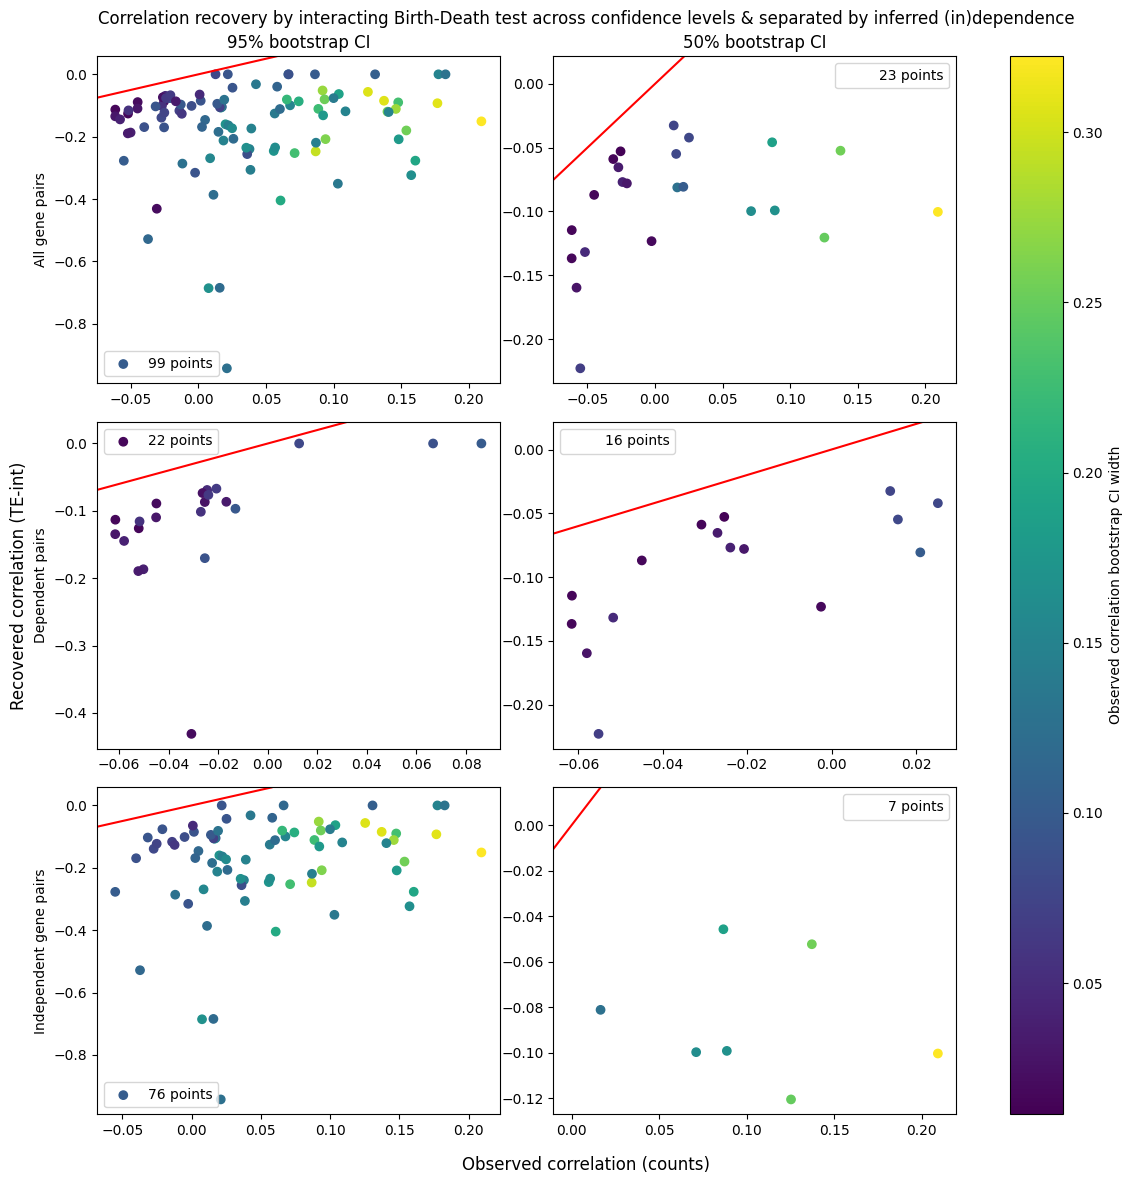

In [113]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:100]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = BD_int_KNone_df[f'counts_d3_c{confidence}_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:100]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Birth-Death test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

### (K = None, 100 pairs) Fixed k_reg = 1

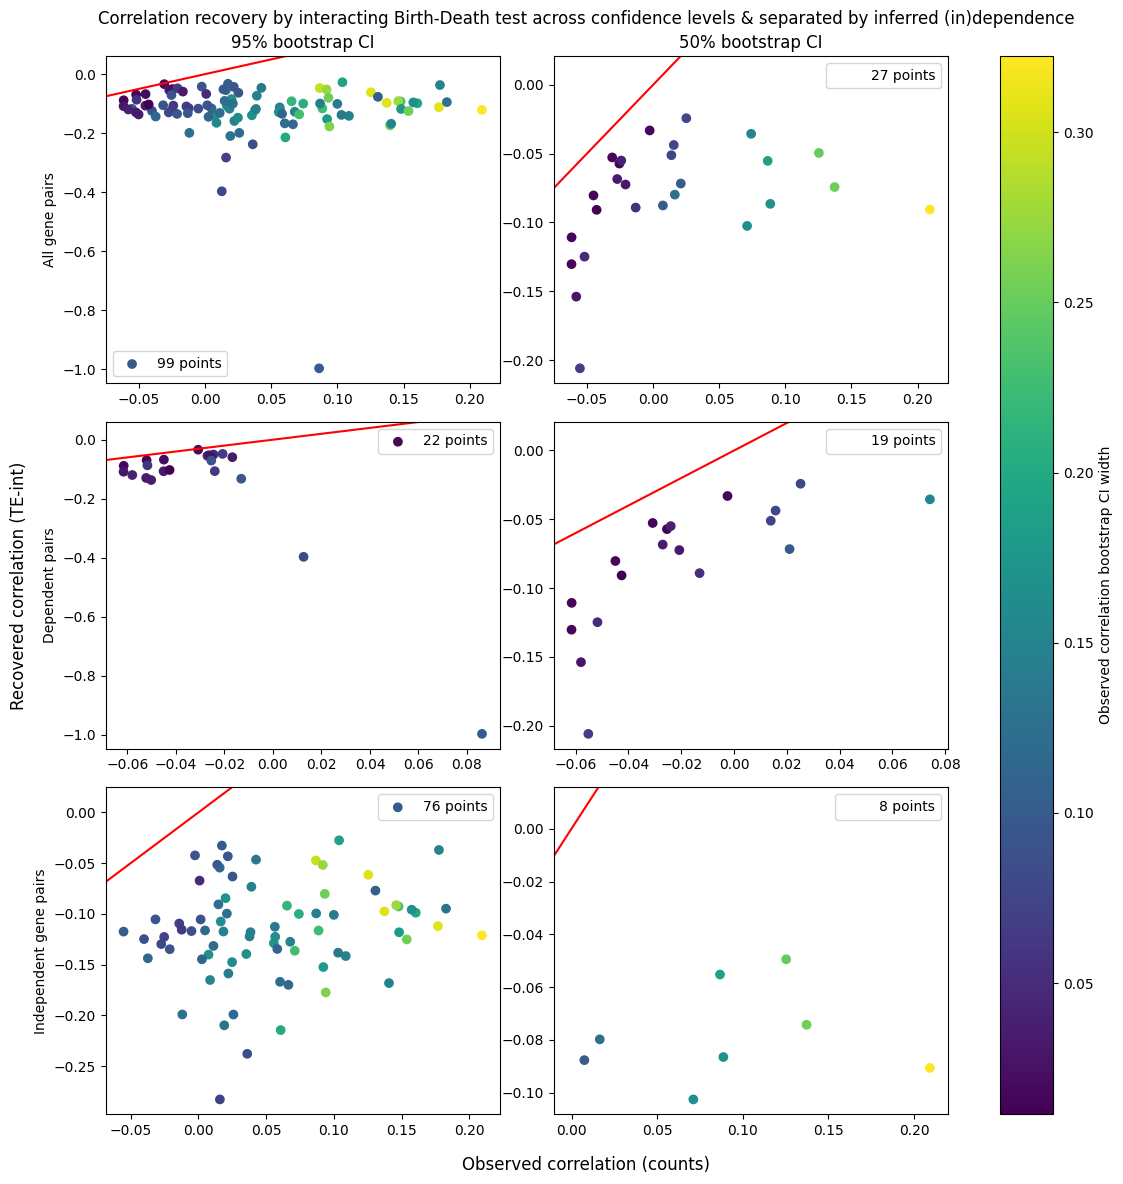

In [115]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:100]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = BD_int_KNone_df[f'counts_d3_c{confidence}_reg_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:100]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Birth-Death test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

### (K = 100, 1000 pairs) Fixed k_deg_2 = 1

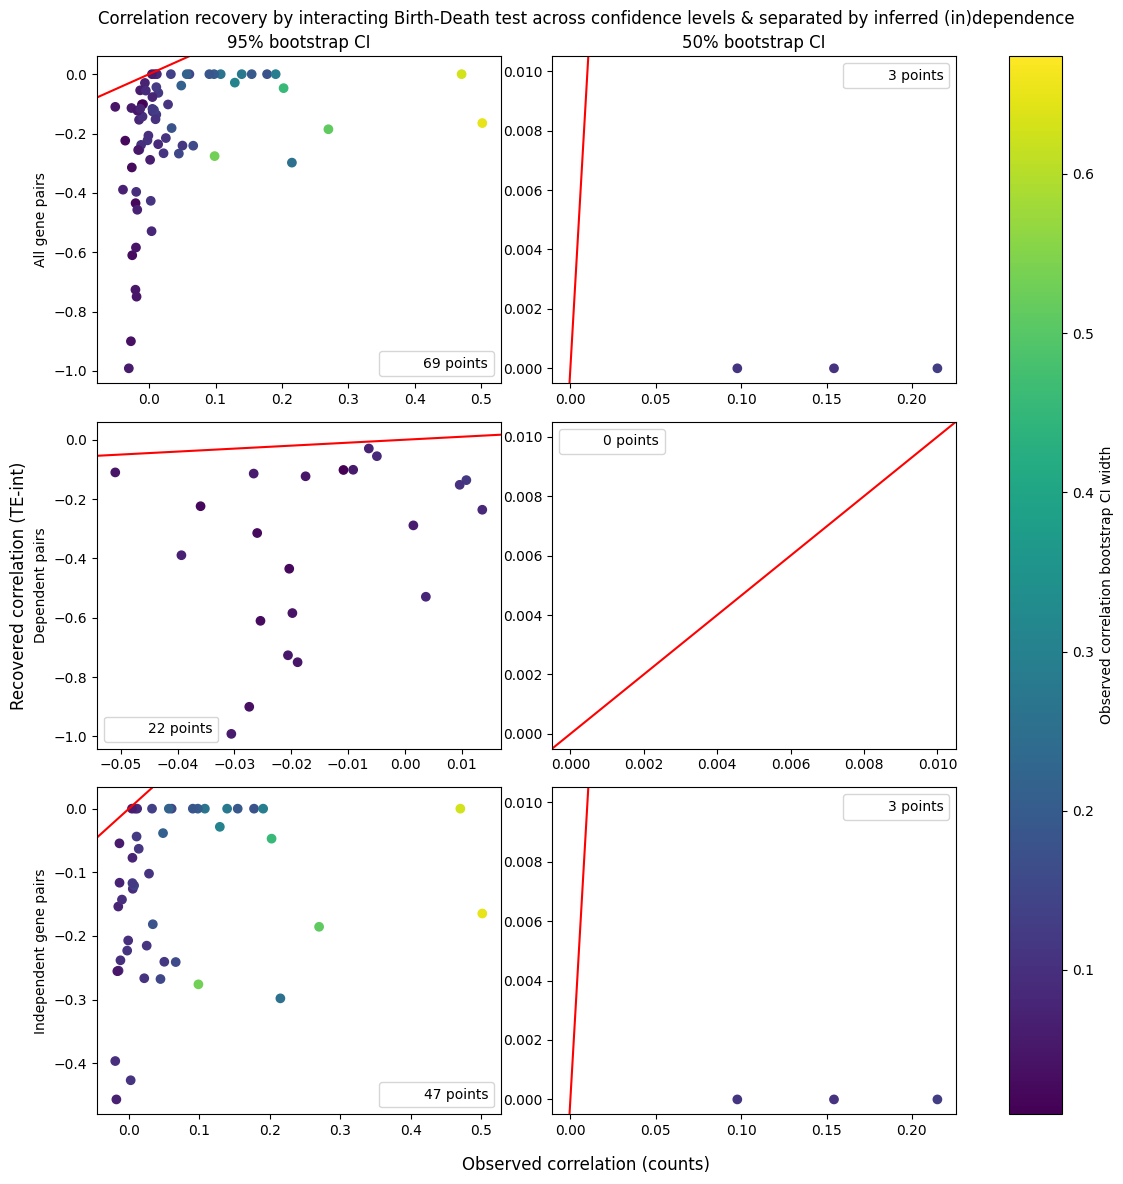

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:1000]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = BD_int_df[f'counts_d3_c{confidence}_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:1000]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Birth-Death test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

### (K = 100, 1000 pairs) Fixed k_reg = 1

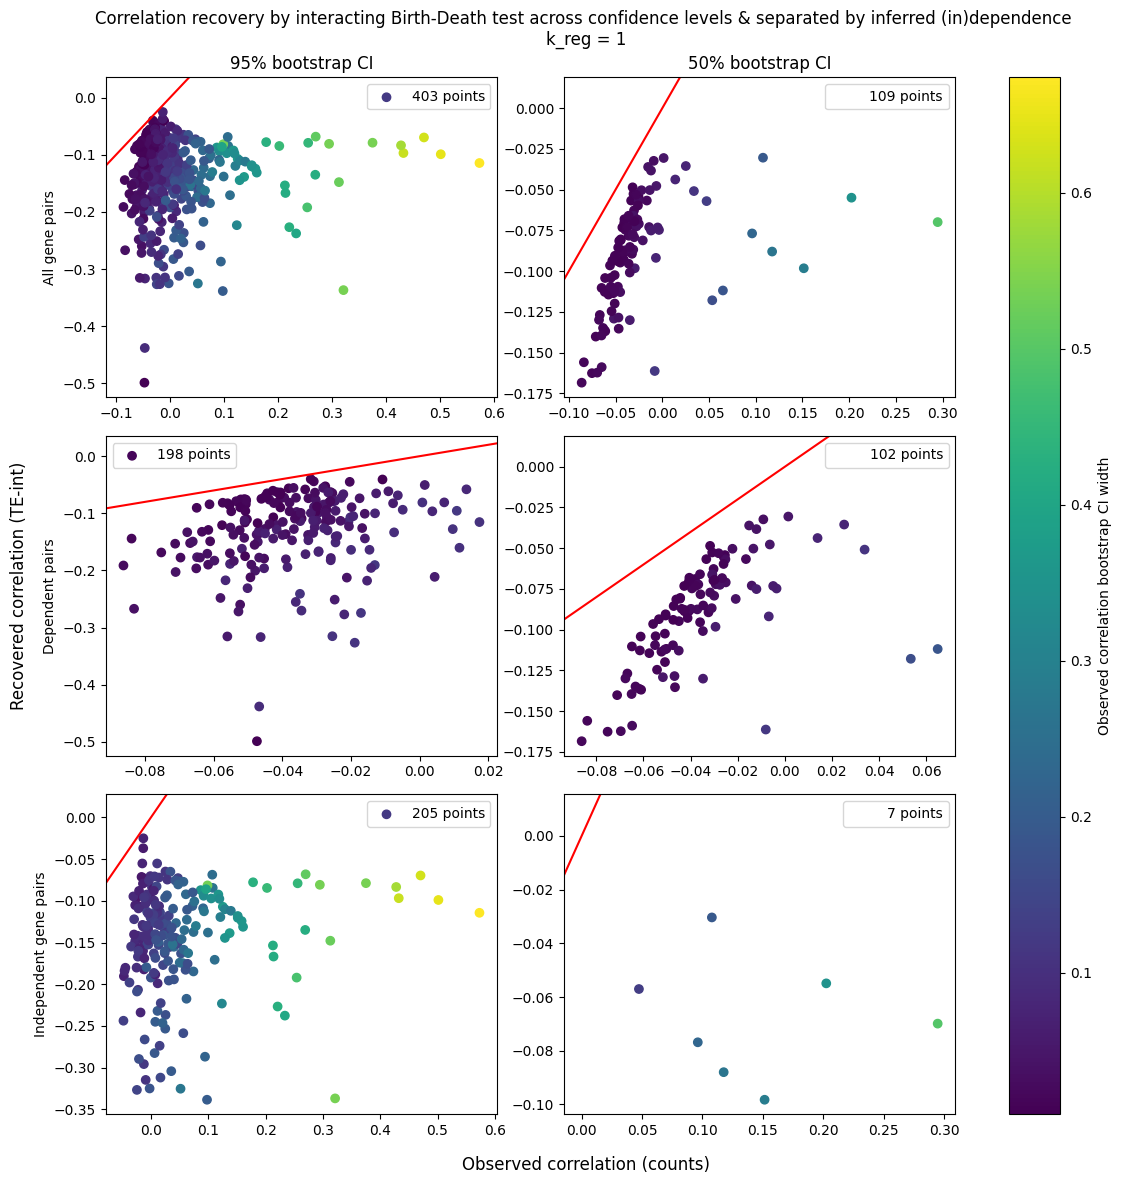

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:1000]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = BD_int_df[f'counts_d3_c{confidence}_reg_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:1000]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Birth-Death test across confidence levels & separated by inferred (in)dependence \nk_reg = 1")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

### Comparison across K & fixed rate

- With K = None is feasibility now consistent across different fixed parameters?
- Are the same correlations recovered by different fixings?
- Are the same correlations recovered with K = 100 and K = None?

#### 95% confidence

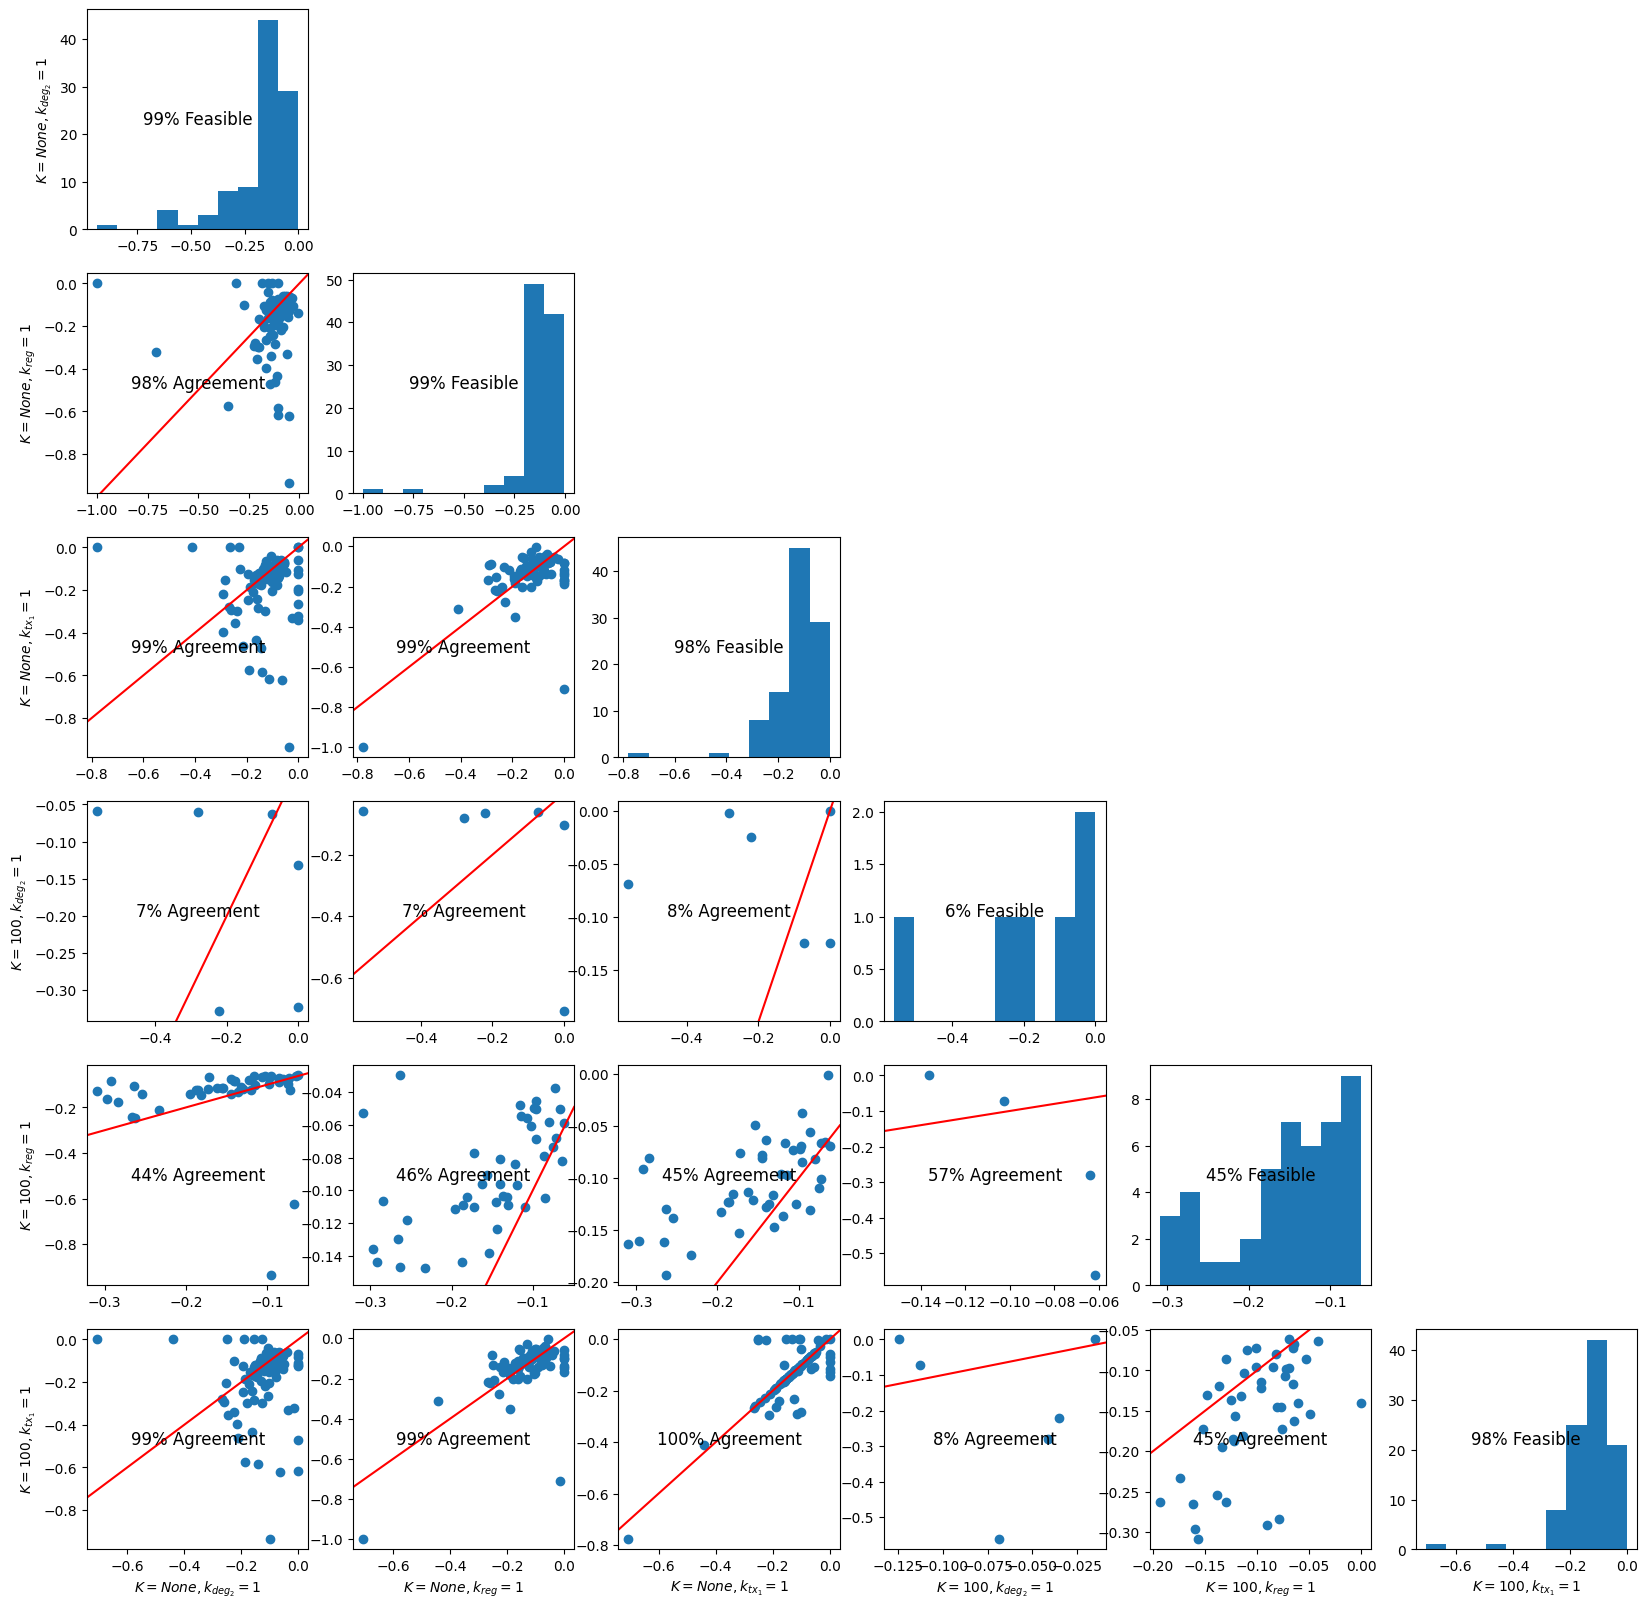

In [184]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

# order and confidence
d = 3
c = 95

diff_list = ["KNone", "reg_KNone", "tx_KNone", "K100", "reg_K100", "tx_K100"]
name_list = [f"counts_d{d}_c{c}_{diff}" for diff in diff_list]

names_fancy = [
    "K = None, k_{deg_2} = 1",
    "K = None, k_{reg} = 1",
    "K = None, k_{tx_1} = 1",
    "K = 100, k_{deg_2} = 1",
    "K = 100, k_{reg} = 1",
    "K = 100, k_{tx_1} = 1"
]

for i, rate_i in enumerate(name_list):

    prefix_i = name_list[i]

    axs[i, 0].set_ylabel(rf"${names_fancy[i]}$")   
    axs[5, i].set_xlabel(rf"${names_fancy[i]}$")

    for j, rate_j in enumerate(name_list):

        prefix_j = name_list[j]

        # diagonal: histogram of correlations, % feasibility
        if i == j:

            feas = (BD_int_comparison_df[f"{prefix_i}_status"] == "OPTIMAL").sum()
            corr = BD_int_comparison_df[f"{prefix_i}_correlation"]
            if corr.notna().sum() > 0:
                axs[i, j].hist(corr, label="Correlation")
            plt.text(0.5, 0.5, f'{feas}% Feasible', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # below: scatter of correlations & % matching feasibility
        if i > j:

            feas_match = (BD_int_comparison_df[f"{prefix_i}_status"] == BD_int_comparison_df[f"{prefix_j}_status"]).sum()
            corr_i = BD_int_comparison_df[f"{prefix_i}_correlation"]
            corr_j = BD_int_comparison_df[f"{prefix_j}_correlation"]
            a = np.mean(corr_i)
            axs[i, j].scatter(corr_i, corr_j, label="Correlation")
            axs[i, j].axline([a, a], [a + 0.001, a + 0.001], color="red")
            plt.text(0.5, 0.5, f'{feas_match}% Agreement', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # above: turn off plot
        if i < j:
            
            fig.delaxes(axs[i, j])

#### 50% confidence

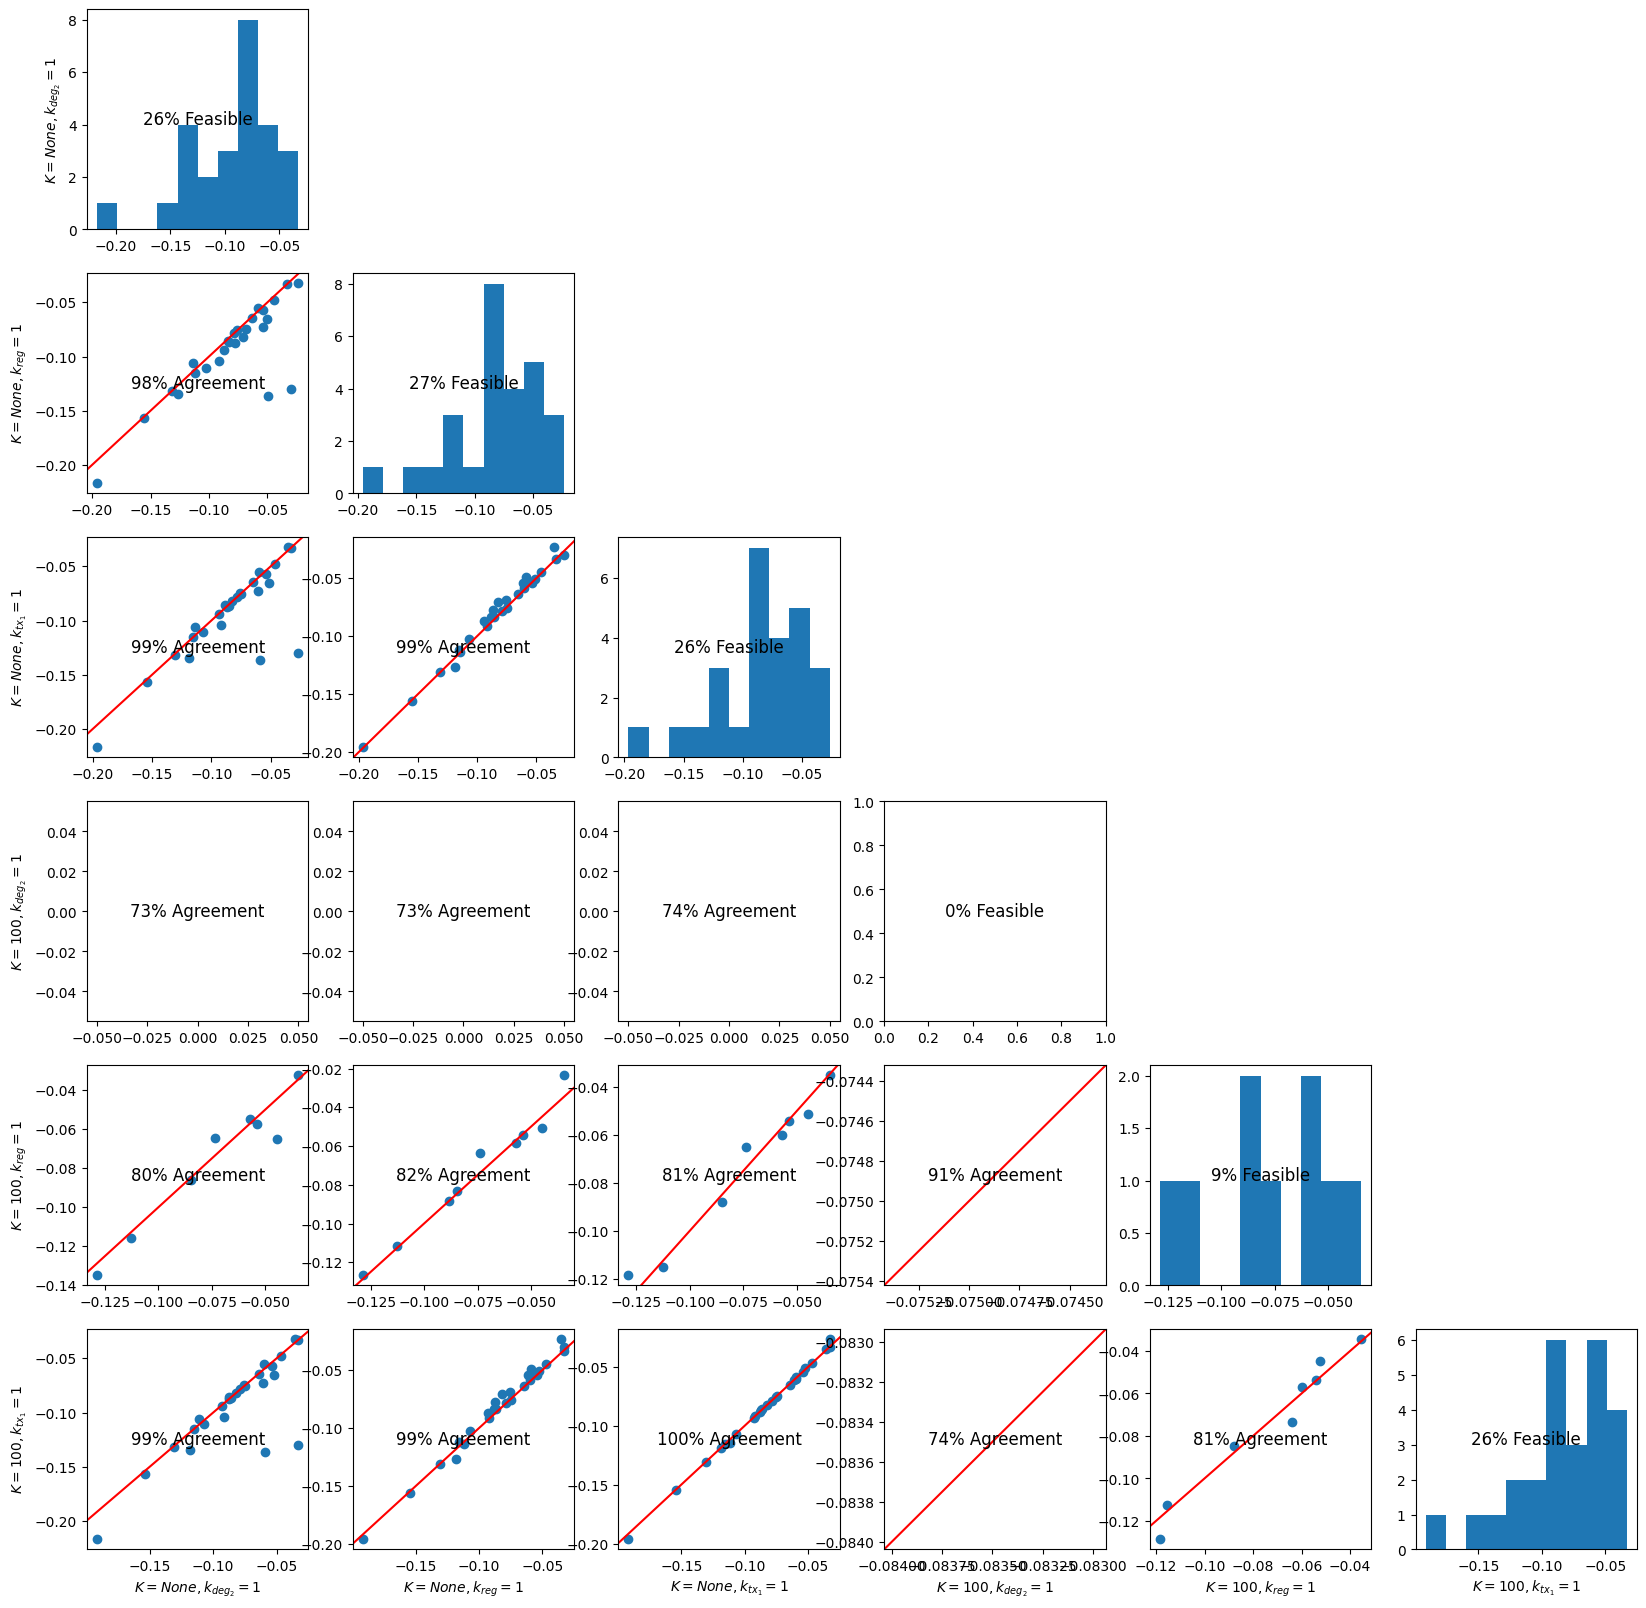

In [185]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

# order and confidence
d = 3
c = 50

diff_list = ["KNone", "reg_KNone", "tx_KNone", "K100", "reg_K100", "tx_K100"]
name_list = [f"counts_d{d}_c{c}_{diff}" for diff in diff_list]

names_fancy = [
    "K = None, k_{deg_2} = 1",
    "K = None, k_{reg} = 1",
    "K = None, k_{tx_1} = 1",
    "K = 100, k_{deg_2} = 1",
    "K = 100, k_{reg} = 1",
    "K = 100, k_{tx_1} = 1"
]

for i, rate_i in enumerate(name_list):

    prefix_i = name_list[i]

    axs[i, 0].set_ylabel(rf"${names_fancy[i]}$")   
    axs[5, i].set_xlabel(rf"${names_fancy[i]}$")

    for j, rate_j in enumerate(name_list):

        prefix_j = name_list[j]

        # diagonal: histogram of correlations, % feasibility
        if i == j:

            feas = (BD_int_comparison_df[f"{prefix_i}_status"] == "OPTIMAL").sum()
            corr = BD_int_comparison_df[f"{prefix_i}_correlation"]
            if corr.notna().sum() > 0:
                axs[i, j].hist(corr, label="Correlation")
            plt.text(0.5, 0.5, f'{feas}% Feasible', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # below: scatter of correlations & % matching feasibility
        if i > j:

            feas_match = (BD_int_comparison_df[f"{prefix_i}_status"] == BD_int_comparison_df[f"{prefix_j}_status"]).sum()
            corr_i = BD_int_comparison_df[f"{prefix_i}_correlation"]
            corr_j = BD_int_comparison_df[f"{prefix_j}_correlation"]
            a = np.mean(corr_i)
            axs[i, j].scatter(corr_i, corr_j, label="Correlation")
            axs[i, j].axline([a, a], [a + 0.001, a + 0.001], color="red")
            plt.text(0.5, 0.5, f'{feas_match}% Agreement', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # above: turn off plot
        if i < j:
            
            fig.delaxes(axs[i, j])

## Telegraph

### (K = None, 100 pairs) Fixed k_deg_2 = 1

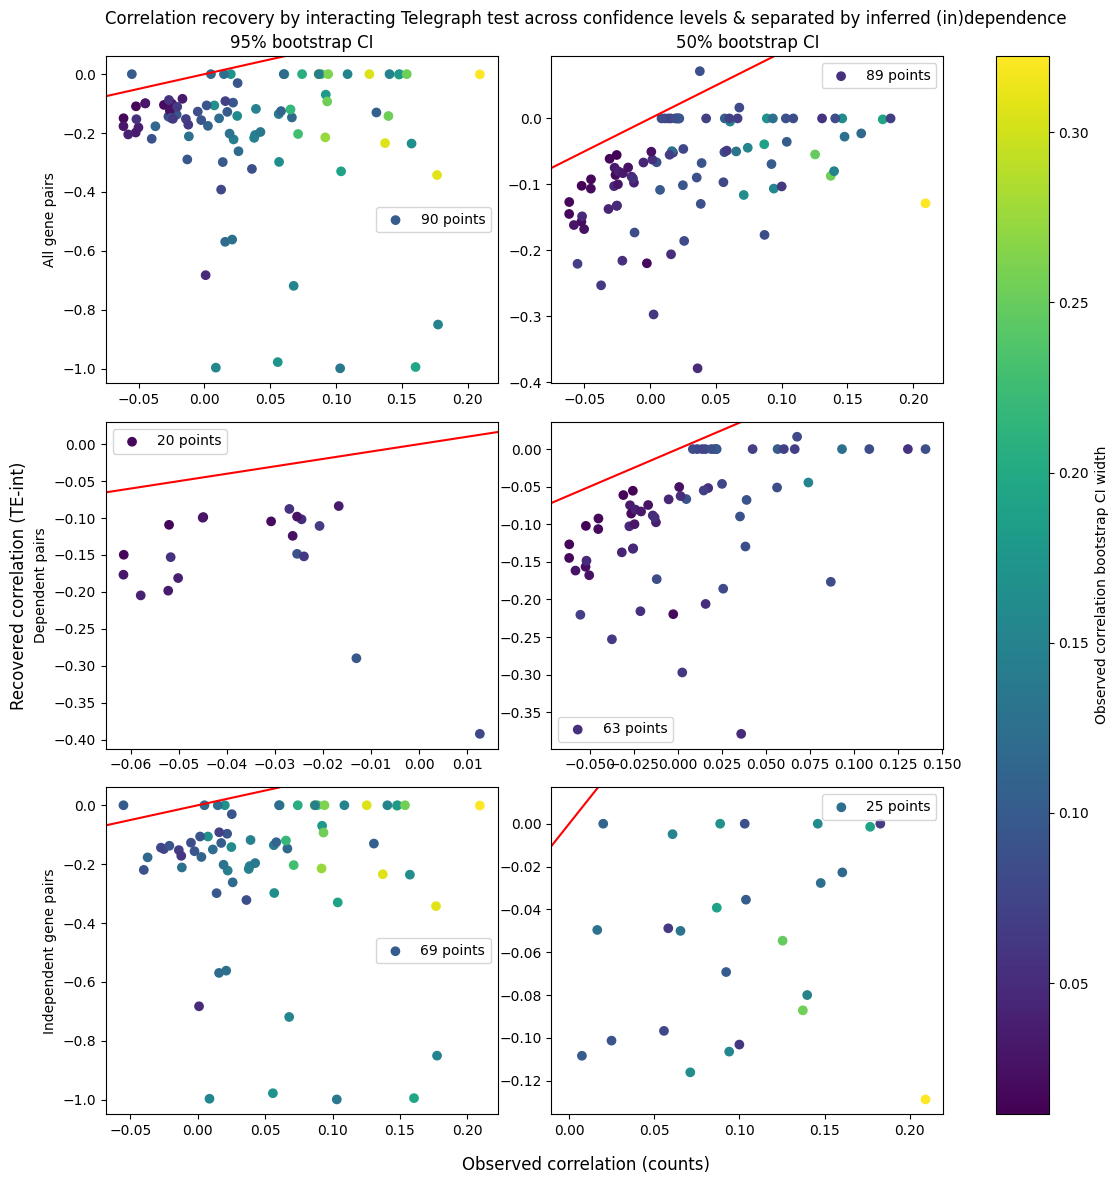

In [207]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:100]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = TE_int_KNone_df[f'counts_d3_c{confidence}_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:100]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Telegraph test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

### (K = 100, 10000 pairs) Fixed k_deg_2 = 1

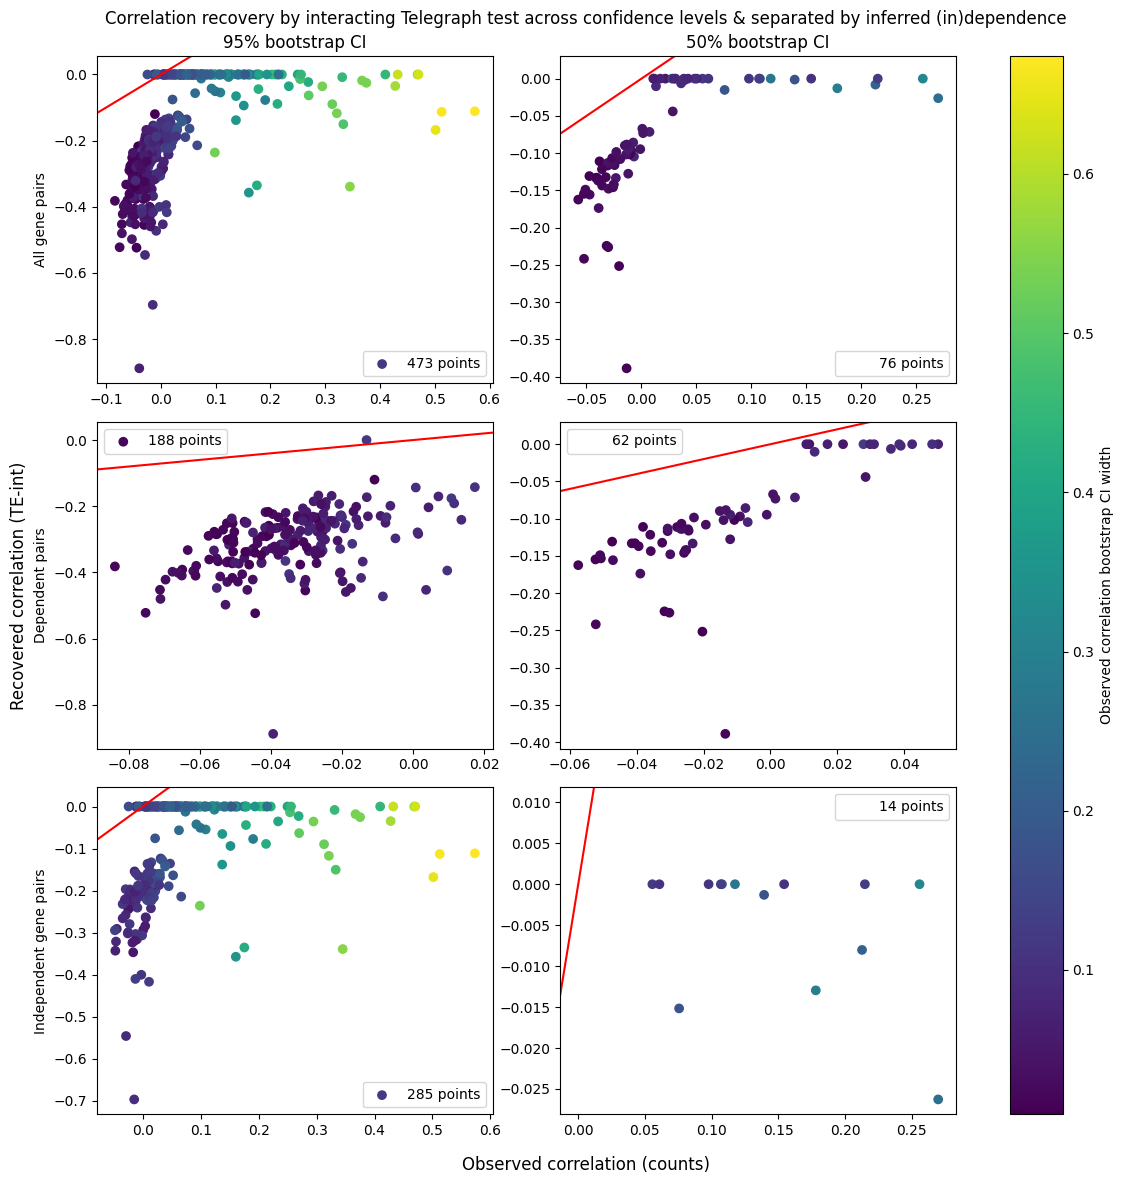

In [530]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

obs_corr = correlation_df['counts_rho'].iloc[:1000]

for j, confidence in enumerate([95, 50]):

    for i in range(3):
        axs[i, j].axline([0, 0], [0.01, 0.01], color="red")#, label="Equality")

    rec_corr = TE_int_df[f'counts_d3_c{confidence}_correlation']
    obs_corr_widths = (correlation_df[f'counts_c{confidence}_ub'] - correlation_df[f'counts_c{confidence}_lb']).iloc[:1000]
    vmin = np.min(obs_corr_widths)
    vmax = np.max(obs_corr_widths)
    mask_na = -rec_corr.isna()
    sc = axs[0, j].scatter(
        obs_corr,
        rec_corr,
        c=obs_corr_widths,
        label=f"{sum(mask_na)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[0, j].legend()

    mask_int = MF_ind_df[f'counts_d4_c{confidence}'] == "INFEASIBLE"
    axs[1, j].scatter(
        obs_corr[mask_int],
        rec_corr[mask_int],
        c=obs_corr_widths[mask_int],
        label=f"{sum(mask_na & mask_int)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[1, j].legend()

    mask_ind = MF_ind_df[f'counts_d4_c{confidence}'] == "OPTIMAL"
    axs[2, j].scatter(
        obs_corr[mask_ind],
        rec_corr[mask_ind],
        c=obs_corr_widths[mask_ind],
        label=f"{sum(mask_na & mask_ind)} points",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    axs[2, j].legend()

    '''
    mask_na = -rec_corr.isna()
    x = obs_corr[mask_na]
    y = rec_corr[mask_na]
    axs[0, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_int].isna()
    x = obs_corr[mask_int][mask_na]
    y = rec_corr[mask_int][mask_na]
    axs[1, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")

    mask_na = -rec_corr[mask_ind].isna()
    x = obs_corr[mask_ind][mask_na]
    y = rec_corr[mask_ind][mask_na]
    axs[2, j].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="orange", label="Line of best fit")
    '''

fig.supxlabel("Observed correlation (counts)")
fig.supylabel("Recovered correlation (TE-int)")
fig.suptitle("Correlation recovery by interacting Telegraph test across confidence levels & separated by inferred (in)dependence")

axs[0, 0].set_ylabel("All gene pairs")
axs[1, 0].set_ylabel("Dependent pairs")
axs[2, 0].set_ylabel("Independent gene pairs")

axs[0, 0].set_title("95% bootstrap CI")
axs[0, 1].set_title("50% bootstrap CI")

plt.tight_layout()

fig.colorbar(sc, ax=axs, label="Observed correlation bootstrap CI width")

# Variability Test (K = None)

Take a dataset of $n$ gene-pairs, for $N$ repeats: bootstrap & optimize. Then look at variability of results across repeats:

(1) % feasibility over $n$ pairs: what is the distribution of this across $N$ repeats \
(2) variance of feasibility (binary) over $N$ runs: what is the distribution of this across $n$ pairs \
(3) variance of correlation over $N$ runs: what is the distribution of this across $n$ pairs

### Results

95% confidence:

(1) all feasible \
(2) all feasible \
(3) correlation variance lower than MF int

50% confidence:

(1) ~5% feasibility range \
(2) feasibility variance comparable to MF ind \
(3) very low correlation variance (lower than MF int)

In [187]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 100
mRNA = data_counts_pcRNA.index[:genes]

In [188]:
# dataframe to store results
variability_MF_ind_df = pd.DataFrame(
    index=mRNA
)
variability_MF_int_df = pd.DataFrame(
    index=mRNA
)
variability_BD_int_df = pd.DataFrame(
    index=mRNA
)
variability_TE_int_df = pd.DataFrame(
    index=mRNA
)

In [189]:
# construct dataset of miRNA paired with all mRNA
dataset = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

## 95% confidence

In [191]:
# settings
N = 10
d = 3
confidence = 0.95

# repeat
for i in tqdm.tqdm(range(N)):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=True)

    # --------------------------------------------------------------------------

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, tqdm_disable=True)
    opt_MF_ind.analyse_dataset()

    # extract feasibility
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    # store
    variability_MF_ind_df[f'status_{i}'] = status

    # --------------------------------------------------------------------------

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, tqdm_disable=True)
    opt_MF_ind.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_MF_ind.result_dict.values()]

    # store
    variability_MF_int_df[f'status_{i}'] = status
    variability_MF_int_df[f'correlation_{i}'] = correlation
    
    # --------------------------------------------------------------------------

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(3, 1)], tqdm_disable=True, K=None)
    opt_BD.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_BD.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_BD.result_dict.values()]

    # store
    variability_BD_int_df[f'status_{i}'] = status
    variability_BD_int_df[f'correlation_{i}'] = correlation

    # --------------------------------------------------------------------------
    '''
    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(7, 1)], tqdm_disable=True, K=None)
    opt_TE.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_TE.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_TE.result_dict.values()]

    # store
    variability_TE_int_df[f'status_{i}'] = status
    variability_TE_int_df[f'correlation_{i}'] = correlation
    '''

100%|██████████| 10/10 [05:58<00:00, 35.86s/it]


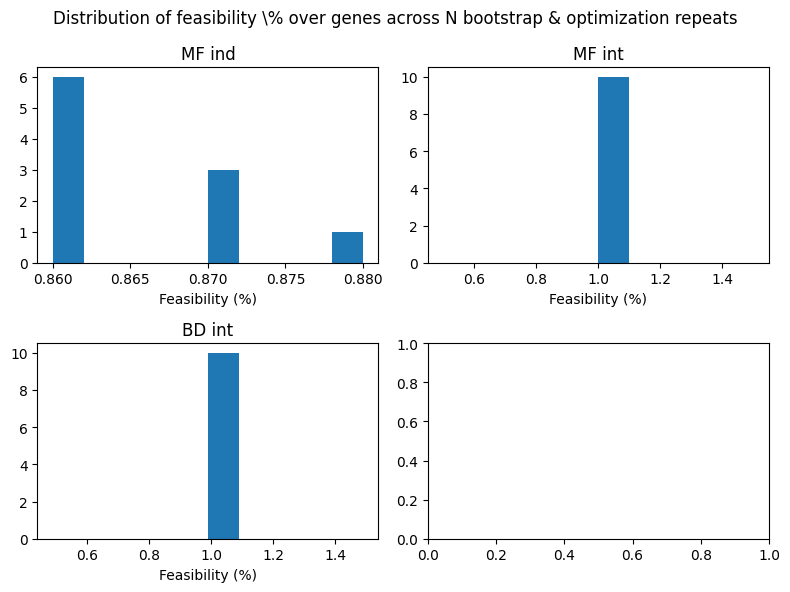

In [192]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility (%)")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility (%)")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility (%)")
#axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Feasibility (%)")
plt.suptitle("Distribution of feasibility \% over genes across N bootstrap & optimization repeats")
plt.tight_layout()

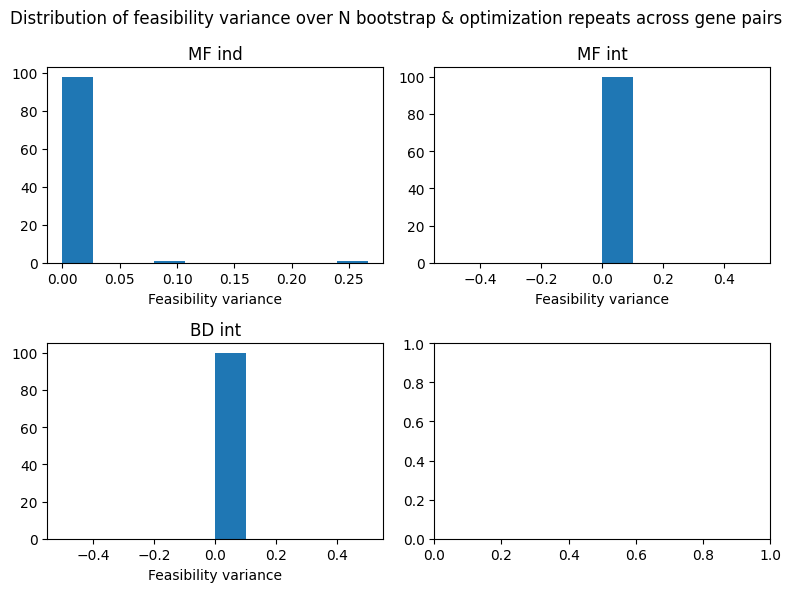

In [193]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility variance")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility variance")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility variance")
#axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Feasibility variance")
plt.suptitle("Distribution of feasibility variance over N bootstrap & optimization repeats across gene pairs")
plt.tight_layout()

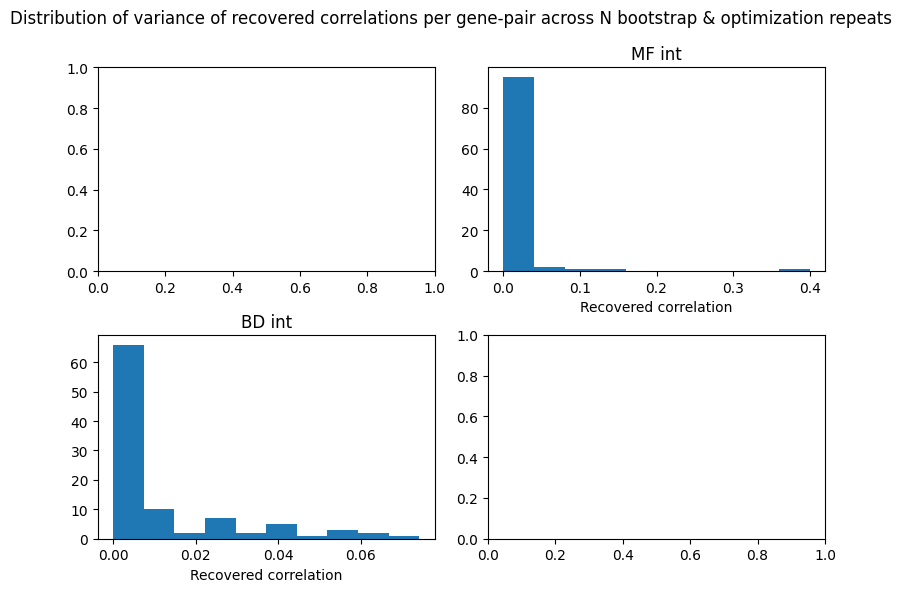

In [194]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
#axs[0, 0].hist((variability_MF_ind_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
#axs[0, 0].set_title("MF ind")
#axs[0, 0].set_xlabel("Recovered correlation")
axs[0, 1].hist((variability_MF_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Recovered correlation")
axs[1, 0].hist((variability_BD_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Recovered correlation")
#axs[1, 1].hist((variability_TE_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Recovered correlation")
plt.suptitle("Distribution of variance of recovered correlations per gene-pair across N bootstrap & optimization repeats")
plt.tight_layout()

## 50% confidence

In [200]:
# settings
N = 10
d = 3
confidence = 0.50

# repeat
for i in tqdm.tqdm(range(N)):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=True)

    # --------------------------------------------------------------------------

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, tqdm_disable=True)
    opt_MF_ind.analyse_dataset()

    # extract feasibility
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    # store
    variability_MF_ind_df[f'status_{i}'] = status

    # --------------------------------------------------------------------------

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True, tqdm_disable=True)
    opt_MF_ind.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_MF_ind.result_dict.values()]

    # store
    variability_MF_int_df[f'status_{i}'] = status
    variability_MF_int_df[f'correlation_{i}'] = correlation
    
    # --------------------------------------------------------------------------

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(3, 1)], tqdm_disable=False, K=None)
    opt_BD.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_BD.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_BD.result_dict.values()]

    # store
    variability_BD_int_df[f'status_{i}'] = status
    variability_BD_int_df[f'correlation_{i}'] = correlation

    # --------------------------------------------------------------------------
    '''
    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(7, 1)], tqdm_disable=True, K=None)
    opt_TE.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_TE.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_TE.result_dict.values()]

    # store
    variability_TE_int_df[f'status_{i}'] = status
    variability_TE_int_df[f'correlation_{i}'] = correlation
    '''

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [28:18<00:00, 169.87s/it]


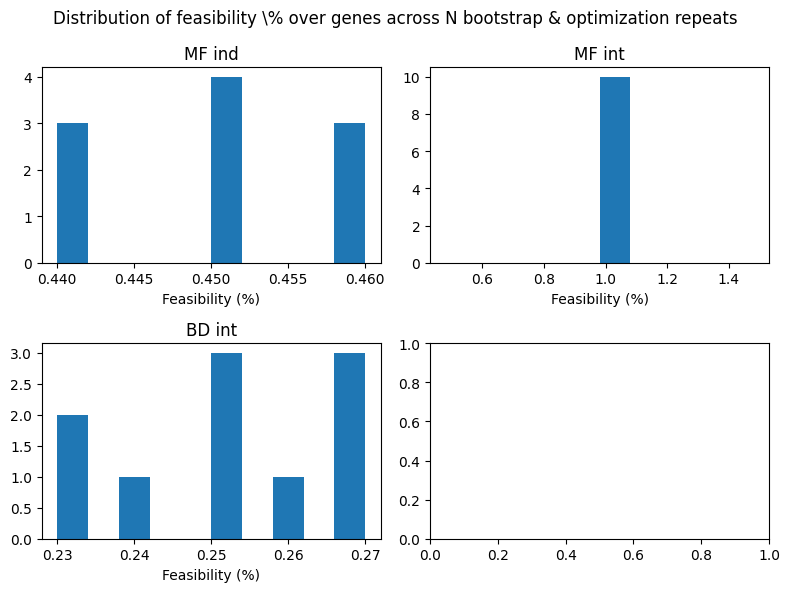

In [201]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility (%)")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility (%)")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility (%)")
#axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Feasibility (%)")
plt.suptitle("Distribution of feasibility \% over genes across N bootstrap & optimization repeats")
plt.tight_layout()

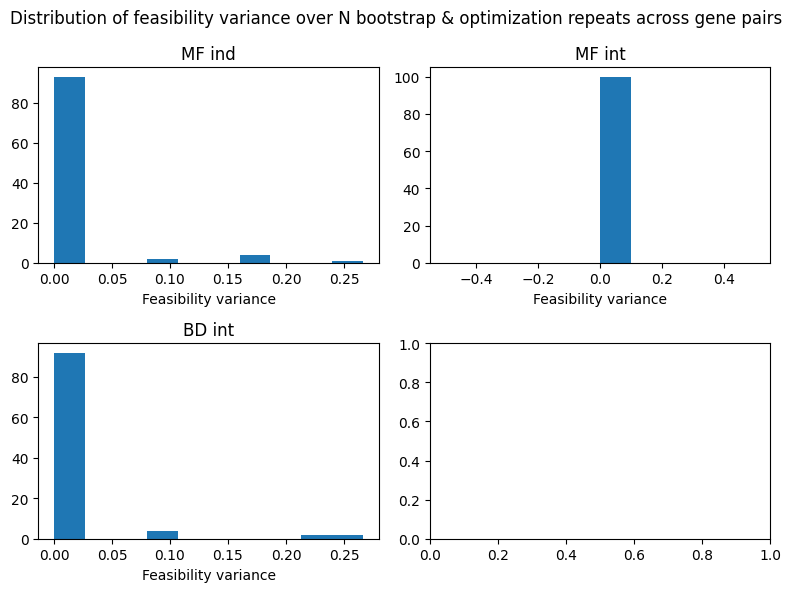

In [202]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility variance")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility variance")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility variance")
#axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Feasibility variance")
plt.suptitle("Distribution of feasibility variance over N bootstrap & optimization repeats across gene pairs")
plt.tight_layout()

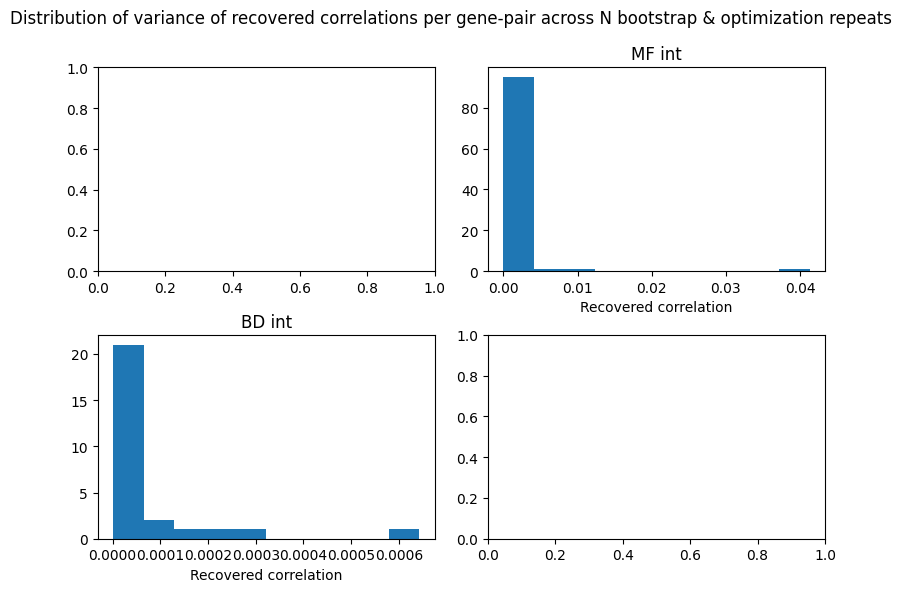

In [203]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
#axs[0, 0].hist((variability_MF_ind_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
#axs[0, 0].set_title("MF ind")
#axs[0, 0].set_xlabel("Recovered correlation")
axs[0, 1].hist((variability_MF_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Recovered correlation")
axs[1, 0].hist((variability_BD_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Recovered correlation")
#axs[1, 1].hist((variability_TE_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
#axs[1, 1].set_title("TE int")
#axs[1, 1].set_xlabel("Recovered correlation")
plt.suptitle("Distribution of variance of recovered correlations per gene-pair across N bootstrap & optimization repeats")
plt.tight_layout()

## Old results (K = 100)

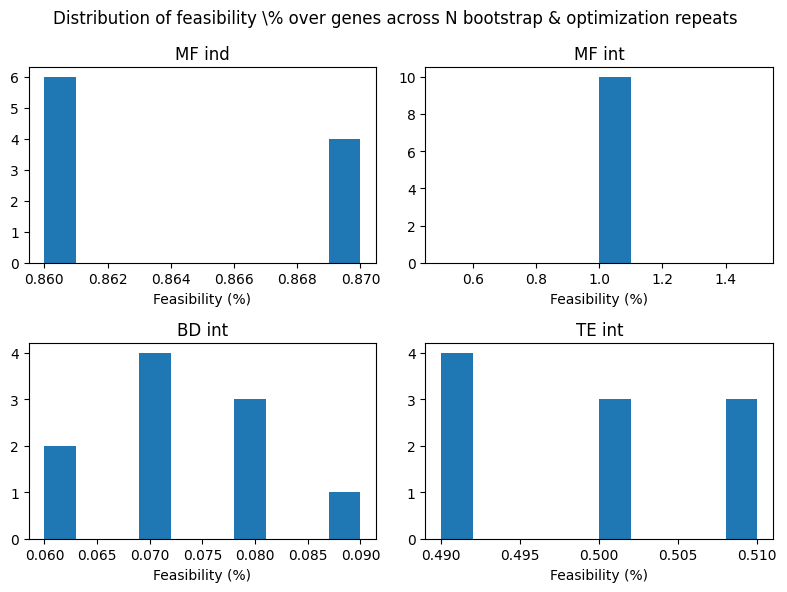

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility (%)")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility (%)")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility (%)")
axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[1, 1].set_title("TE int")
axs[1, 1].set_xlabel("Feasibility (%)")
plt.suptitle("Distribution of feasibility \% over genes across N bootstrap & optimization repeats")
plt.tight_layout()

Over repeats the % feasibility is very consistent
- ~87% for MF ind
- 100% for MF int
- ~<1% for BD int
- ~50% for TE int

Intuitive results: more general models have higher feasibility, still many infeasible under TE

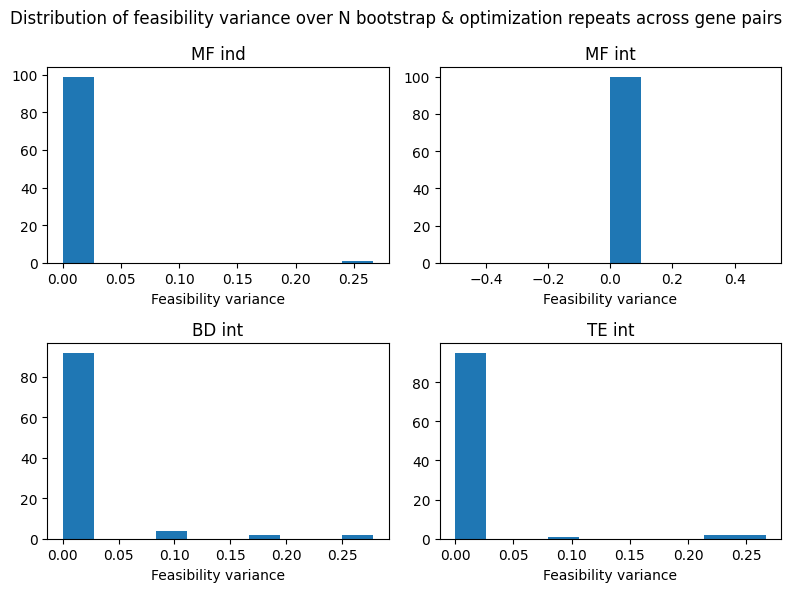

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].hist((variability_MF_ind_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Feasibility variance")
axs[0, 1].hist((variability_MF_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Feasibility variance")
axs[1, 0].hist((variability_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Feasibility variance")
axs[1, 1].hist((variability_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[1, 1].set_title("TE int")
axs[1, 1].set_xlabel("Feasibility variance")
plt.suptitle("Distribution of feasibility variance over N bootstrap & optimization repeats across gene pairs")
plt.tight_layout()

Across genes most have 0 variance in feasibility over repeats
- only a few genes have non-zero variance for BD and TE results

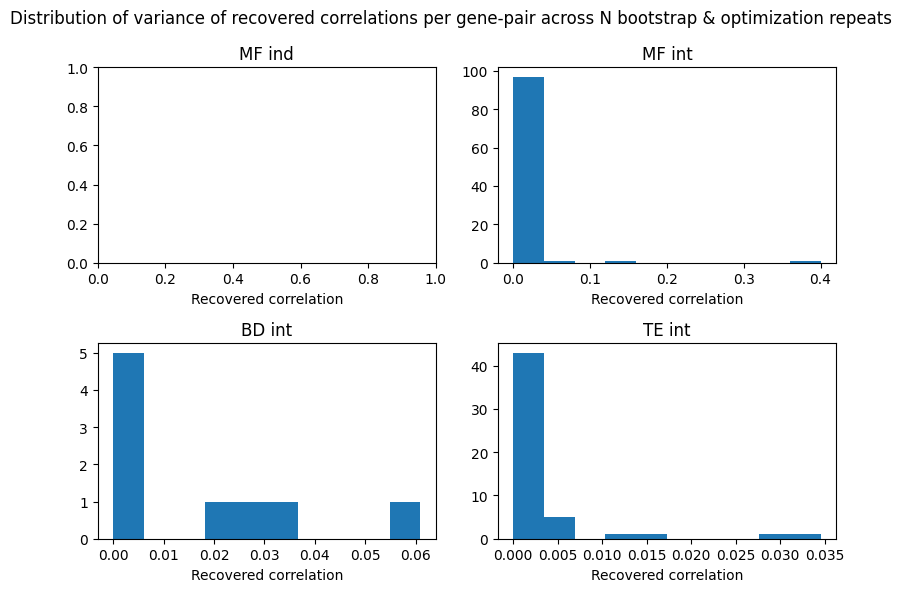

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
#axs[0, 0].hist((variability_MF_ind_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 0].set_title("MF ind")
axs[0, 0].set_xlabel("Recovered correlation")
axs[0, 1].hist((variability_MF_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 1].set_title("MF int")
axs[0, 1].set_xlabel("Recovered correlation")
axs[1, 0].hist((variability_BD_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[1, 0].set_title("BD int")
axs[1, 0].set_xlabel("Recovered correlation")
axs[1, 1].hist((variability_TE_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[1, 1].set_title("TE int")
axs[1, 1].set_xlabel("Recovered correlation")
plt.suptitle("Distribution of variance of recovered correlations per gene-pair across N bootstrap & optimization repeats")
plt.tight_layout()

### Notes

- single bootstrap, then N optimization repeats seems to produce identical results (feasibility & correlations)
- N boostrap & optimization repeats also seem to have low variability across repeats
    - dist(% feasibility across gene pairs) per repeat
    - dist(variance of feasibility / correlation across repeats) per gene pair)

### k_reg = 1

In [88]:
# dataframe to store results
variability_reg_BD_int_df = pd.DataFrame(
    index=mRNA
)
variability_reg_TE_int_df = pd.DataFrame(
    index=mRNA
)

In [90]:
# settings
N = 10
d = 3
confidence = 0.95

# repeat
for i in tqdm.tqdm(range(N)):

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=True)

    # --------------------------------------------------------------------------

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(4, 1)], tqdm_disable=True)
    opt_BD.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_BD.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_BD.result_dict.values()]

    # store
    variability_reg_BD_int_df[f'status_{i}'] = status
    variability_reg_BD_int_df[f'correlation_{i}'] = correlation

    # --------------------------------------------------------------------------

    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(8, 1)], tqdm_disable=True)
    opt_TE.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_TE.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_TE.result_dict.values()]

    # store
    variability_reg_TE_int_df[f'status_{i}'] = status
    variability_reg_TE_int_df[f'correlation_{i}'] = correlation

100%|██████████| 10/10 [05:11<00:00, 31.13s/it]


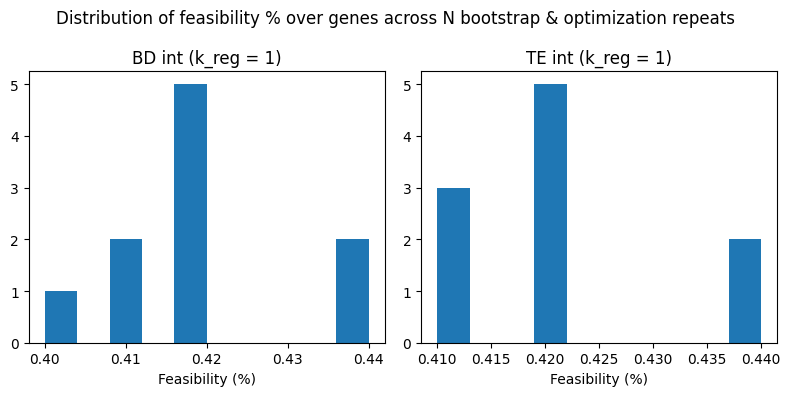

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
axs[0, 0].hist((variability_reg_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 0].set_title("BD int (k_reg = 1)")
axs[0, 0].set_xlabel("Feasibility (%)")
axs[0, 1].hist((variability_reg_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").mean());
axs[0, 1].set_title("TE int (k_reg = 1)")
axs[0, 1].set_xlabel("Feasibility (%)")
plt.suptitle("Distribution of feasibility % over genes across N bootstrap & optimization repeats")
plt.tight_layout()

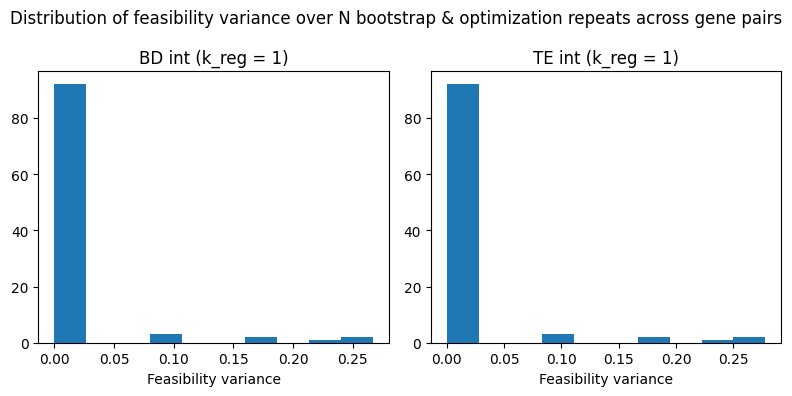

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
axs[0, 0].hist((variability_reg_BD_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 0].set_title("BD int (k_reg = 1)")
axs[0, 0].set_xlabel("Feasibility variance")
axs[0, 1].hist((variability_reg_TE_int_df[[f'status_{i}' for i in range(N)]] == "OPTIMAL").var(axis=1));
axs[0, 1].set_title("TE int (k_reg = 1)")
axs[0, 1].set_xlabel("Feasibility variance")
plt.suptitle("Distribution of feasibility variance over N bootstrap & optimization repeats across gene pairs")
plt.tight_layout()

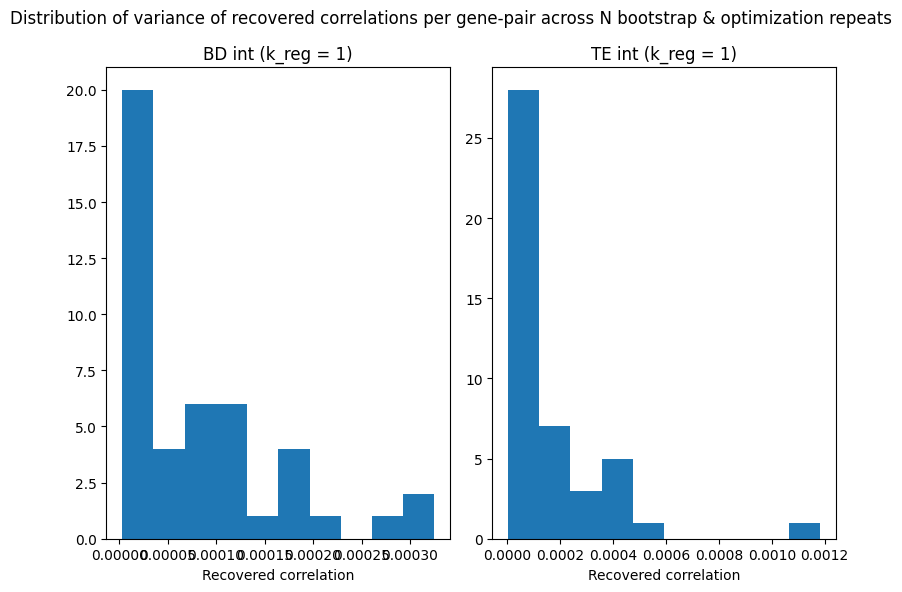

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6), squeeze=False)
axs[0, 0].hist((variability_reg_BD_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 0].set_title("BD int (k_reg = 1)")
axs[0, 0].set_xlabel("Recovered correlation")
axs[0, 1].hist((variability_reg_TE_int_df[[f'correlation_{i}' for i in range(N)]]).var(axis=1));
axs[0, 1].set_title("TE int (k_reg = 1)")
axs[0, 1].set_xlabel("Recovered correlation")
plt.suptitle("Distribution of variance of recovered correlations per gene-pair across N bootstrap & optimization repeats")
plt.tight_layout()

# Fixed Rate Test

Take $n$ gene-pairs, bootstrap and then for each rate optimize with that rate fixed to 1: compare feasibility and correlation over different rates to see any differences

### Results
- K = 100 too low and cutting off parameters values, changing to K = None means much more feasible
- K = None means fixing any rate gives identical results
    - even fixing $k_{reg}$, as this is ~never exactly 0 and so can always scale rates to get the same feasible point (so same feasibility and recovered correlation)
- K = 10,000 very similar results to K = None

In [96]:
# selected miRNA
miRNA = "MIR100"

# selected mRNA
genes = 100
mRNA = data_counts_pcRNA.index[:genes]

In [97]:
# dataframe to store results
fixed_df = pd.DataFrame(
    index=mRNA
)

In [98]:
# construct dataset of miRNA paired with all mRNA
dataset = construct_dataset(data_counts_miRNA.loc[miRNA], data_counts_pcRNA.loc[mRNA], beta_counts)

In [ ]:
# settings
d = 3
confidence = 0.95

# used wrong names
# rate_names =["k_tx_1", "k_tx_2", "k_deg_1", "k_deg_2", "k_reg"]
# should be
rate_names =["k_tx_1", "k_deg_1", "k_tx_2", "k_deg_2", "k_reg"]

# bootstrap
dataset.confidence = confidence
dataset.bootstrap(d, tqdm_disable=True)

for k, rate in enumerate(rate_names):

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=[(k, 1)], K=None, tqdm_disable=False)
    opt_BD.analyse_dataset()

    # extract status
    status = [solution['status'] for solution in opt_BD.result_dict.values()]

    # extract recovered correlation
    correlation = [solution['correlation'] for solution in opt_BD.result_dict.values()]

    # store
    fixed_df[f'status_{rate}'] = status
    fixed_df[f'correlation_{rate}'] = correlation

100%|██████████| 100/100 [05:07<00:00,  3.08s/it]


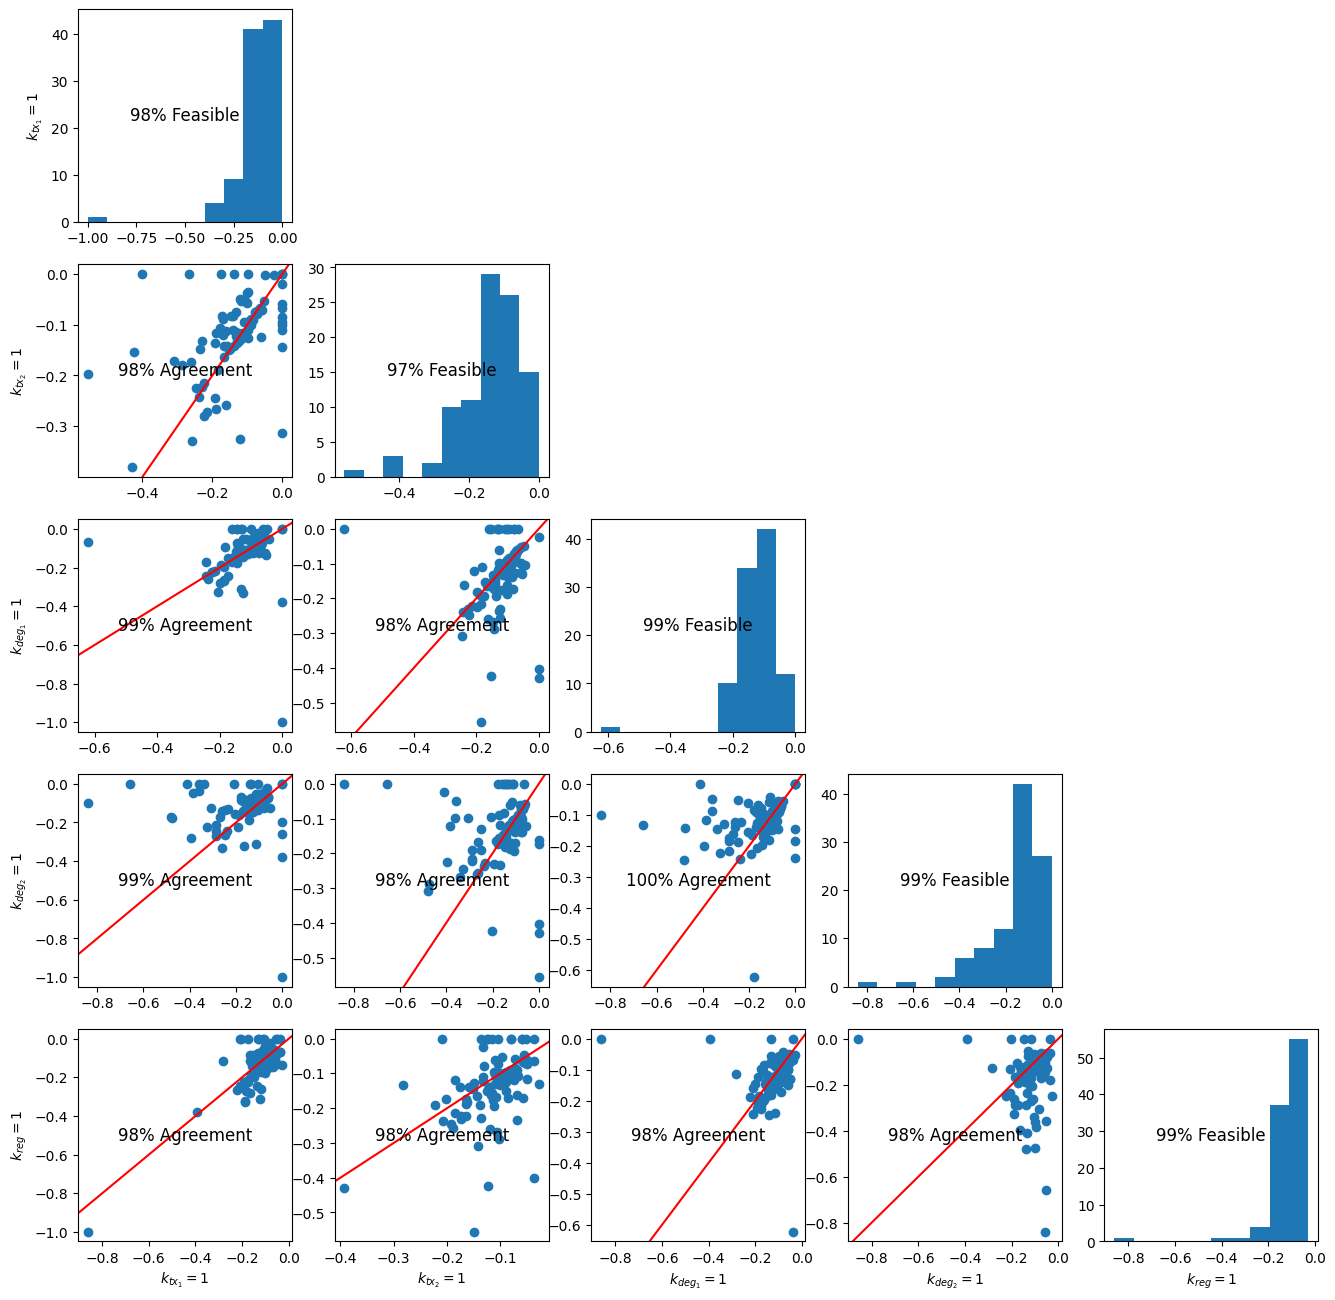

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(16, 16))
# rate_names_fancy = ["k_{tx_1}", "k_{tx_2}", "k_{deg_1}", "k_{deg_2}", "k_{reg}"] wrong order labels
rate_names_fancy = ["k_{tx_1}", "k_{deg_1}", "k_{tx_2}", "k_{deg_2}", "k_{reg}"]
for i, rate_i in enumerate(rate_names):

    axs[i, 0].set_ylabel(rf"${rate_names_fancy[i]} = 1$")   
    axs[4, i].set_xlabel(rf"${rate_names_fancy[i]} = 1$")

    for j, rate_j in enumerate(rate_names):

        # diagonal: histogram of correlations, % feasibility
        if i == j:

            feas = (fixed_df[f'status_{rate_i}'] == "OPTIMAL").sum()
            corr = fixed_df[f'correlation_{rate_i}']
            axs[i, j].hist(corr, label="Correlation")
            plt.text(0.5, 0.5, f'{feas}% Feasible', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # below: scatter of correlations & % matching feasibility
        if i > j:

            feas_match = (fixed_df[f'status_{rate_i}'] == fixed_df[f'status_{rate_j}']).sum()
            corr_i = fixed_df[f'correlation_{rate_i}']
            corr_j = fixed_df[f'correlation_{rate_j}']
            a = np.mean(corr_i)
            axs[i, j].scatter(corr_i, corr_j, label="Correlation")
            axs[i, j].axline([a, a], [a + 0.001, a + 0.001], color="red")
            plt.text(0.5, 0.5, f'{feas_match}% Agreement', horizontalalignment='center', verticalalignment='center', transform = axs[i, j].transAxes, fontsize=12)

        # above: turn off plot
        if i < j:
            
            fig.delaxes(axs[i, j])

In [ ]:
# feasible reaction rates of each gene-pair for k_reg = 1
[[dict_list[-1][f'k[{r}]'] for r in range(5)] for dict_list in opt_BD.feasible_values_dict.values()]

[[303.41947943311555,
  0.203217691319303,
  301.293886320603,
  0.05388162505053296,
  1.0],
 [1447.6102237061557,
  0.5977524073074381,
  1443.6838591653961,
  0.06183955355949901,
  1.0],
 [1014.3548380352248,
  0.34274006995243655,
  1017.2641390458257,
  0.13911264029405895,
  1.0],
 [234.13792156525858,
  0.0796205201935327,
  234.19095483888594,
  0.045690936335627874,
  1.0],
 [839.3989085792919,
  0.3272795824588766,
  839.3922372478946,
  0.09178629032340811,
  1.0],
 [4022.856548002834,
  0.9908079745747098,
  4017.984023759623,
  0.04151715007684715,
  1.0],
 [1282.2550058980432,
  0.3065023905951061,
  1282.488715338661,
  0.02734840113731295,
  1.0],
 [1650.3813434216659,
  0.6554982666648425,
  1651.8151982014351,
  0.10458194017577756,
  1.0],
 [1175.9808963550781,
  0.4033807552455228,
  1174.7203625210338,
  0.06304908122703877,
  1.0],
 [78.65727636986995,
  0.022788186638093108,
  78.6479791373613,
  0.004736819140676286,
  1.0],
 [468.27467413689106,
  0.3029580008

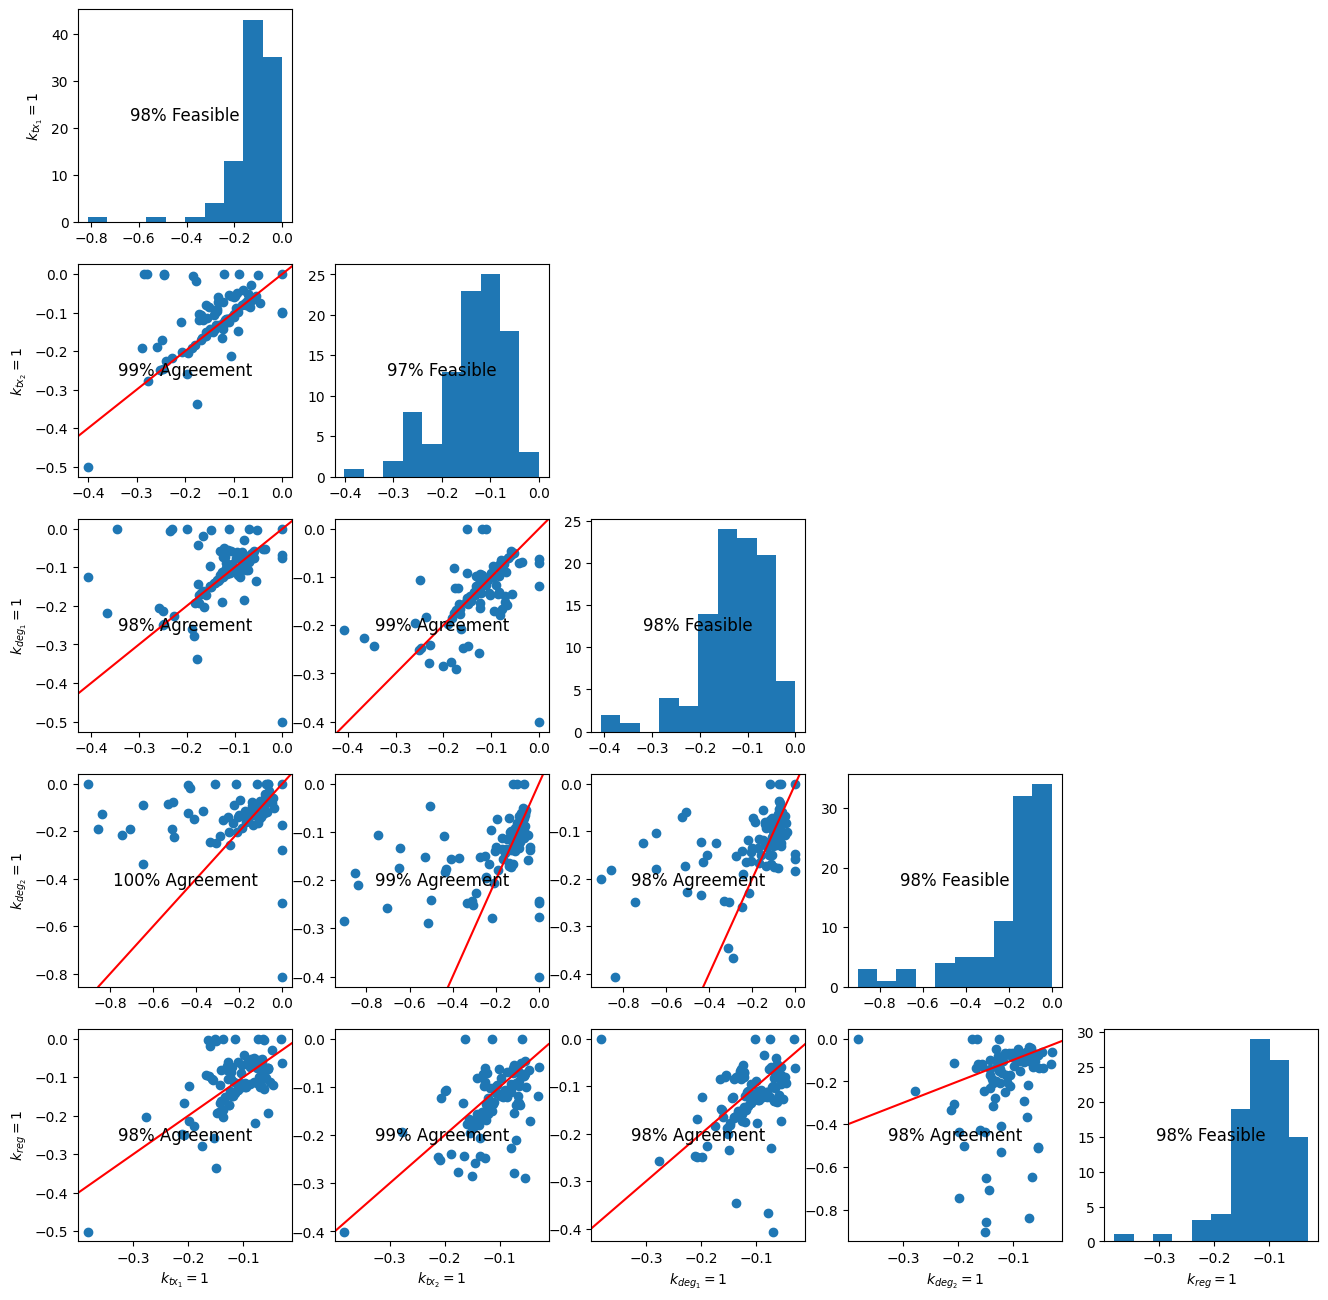

In [ ]:
# K = 10,000

## (K = None) Feasible reaction rate values

### k_reg = 1

100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


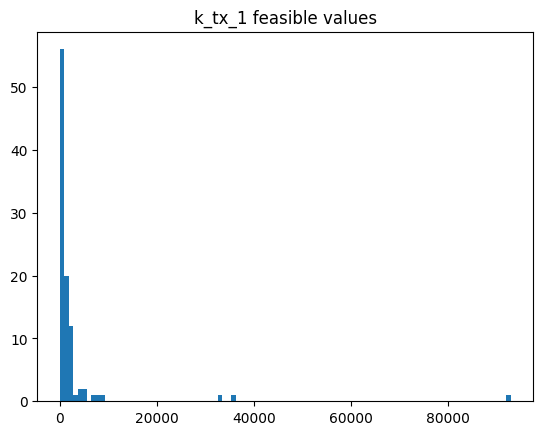

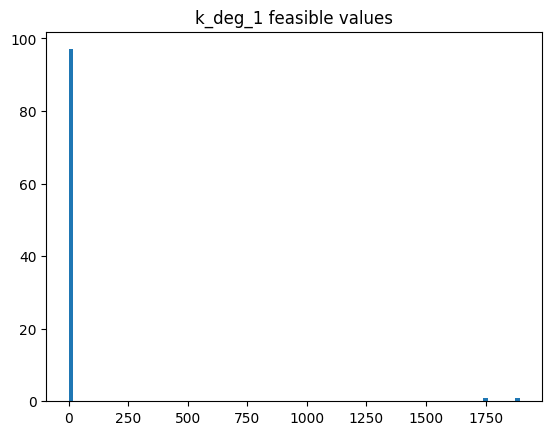

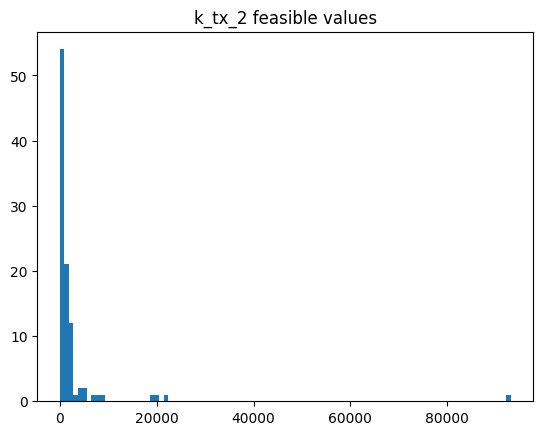

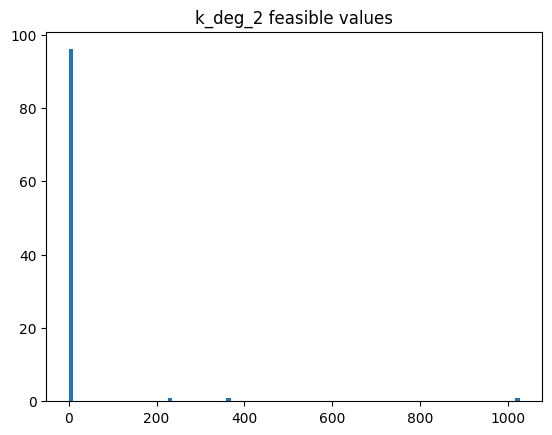

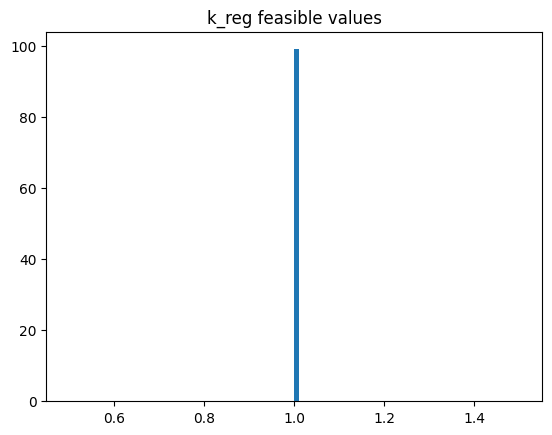

In [93]:
dataset = dataset_counts
confidence = 0.95
d = 3
fixed = [(4, 1)]
K = None

# bootstrap
dataset.confidence = confidence
dataset.bootstrap(d, tqdm_disable=False)

# Interacting birth death
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed, K=K)
opt_BD.analyse_dataset()

rate_names = ['k_tx_1', 'k_deg_1', 'k_tx_2', 'k_deg_2', 'k_reg']
feasible_rates = np.empty((5, 100))
for i in range(100):
    if opt_BD.result_dict[i]['status'] == "OPTIMAL":
        feasible_point = opt_BD.feasible_values_dict[i][-1]
        for r in range(5):
            feasible_rates[r, i] = feasible_point[f'k[{r}]']
    else:
        feasible_rates[:, i] = None

for r, rate in enumerate(rate_names):
    vals = feasible_rates[r, :]
    plt.hist(vals, bins=100);
    plt.title(f"{rate} feasible values")
    plt.show()

### k_tx_1 = 1

100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


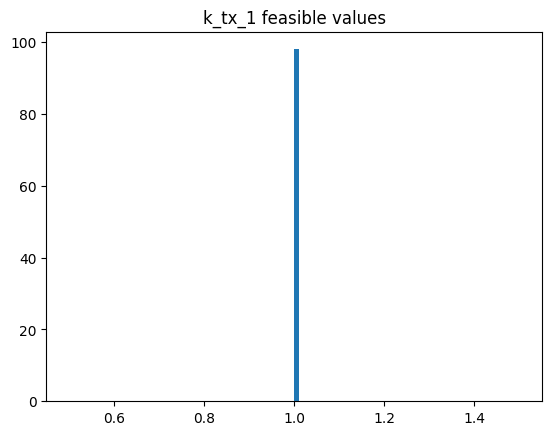

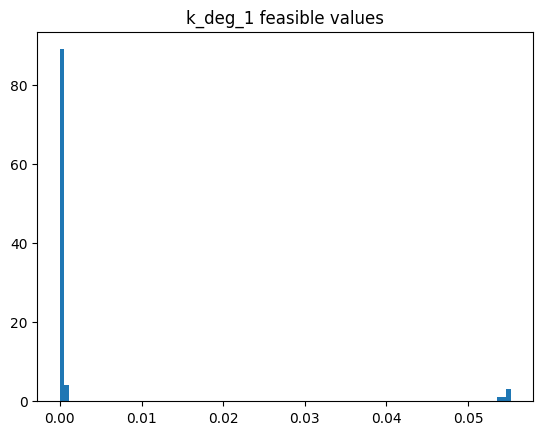

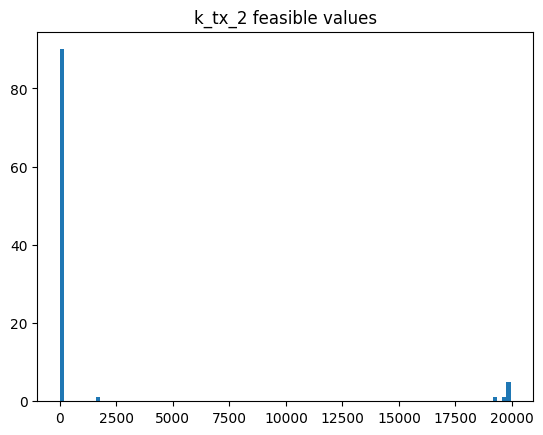

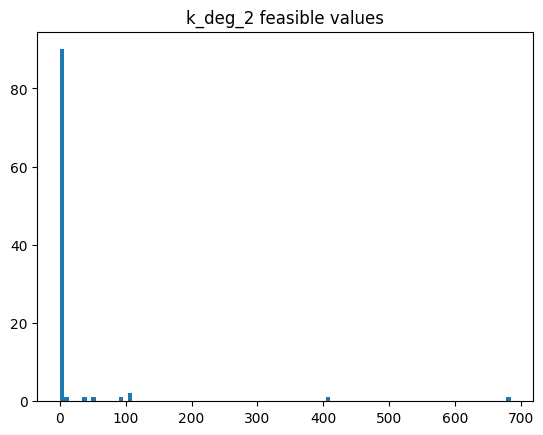

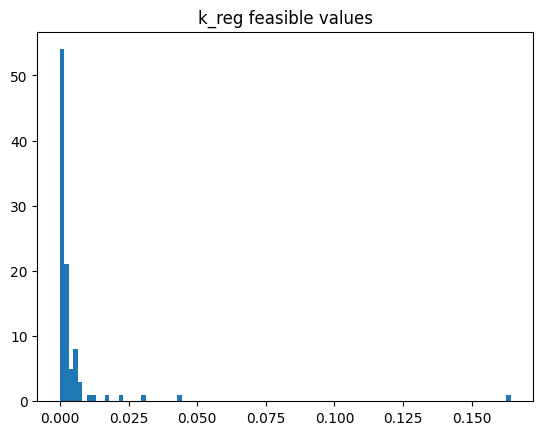

In [94]:
dataset = dataset_counts
confidence = 0.95
d = 3
fixed = [(0, 1)]
K = None

# bootstrap
dataset.confidence = confidence
dataset.bootstrap(d, tqdm_disable=False)

# Interacting birth death
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed, K=K)
opt_BD.analyse_dataset()

rate_names = ['k_tx_1', 'k_deg_1', 'k_tx_2', 'k_deg_2', 'k_reg']
feasible_rates_tx_1 = np.empty((5, 100))
for i in range(100):
    if opt_BD.result_dict[i]['status'] == "OPTIMAL":
        feasible_point = opt_BD.feasible_values_dict[i][-1]
        for r in range(5):
            feasible_rates_tx_1[r, i] = feasible_point[f'k[{r}]']
    else:
        feasible_rates_tx_1[:, i] = None

for r, rate in enumerate(rate_names):
    vals = feasible_rates_tx_1[r, :]
    plt.hist(vals, bins=100);
    plt.title(f"{rate} feasible values")
    plt.show()

#### 50% confidence

100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


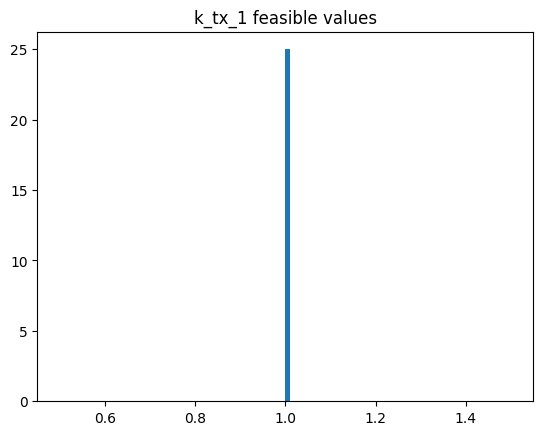

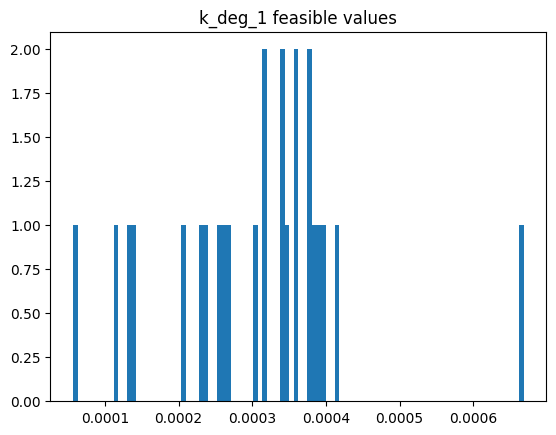

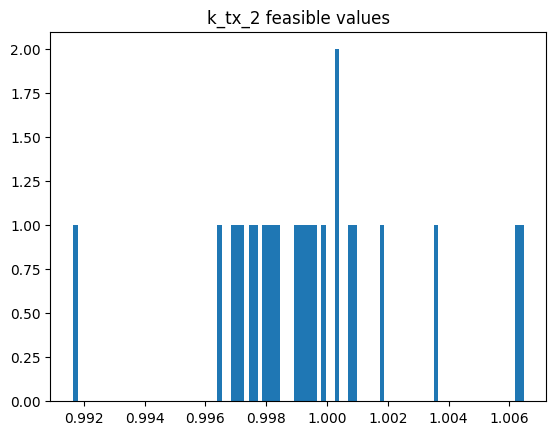

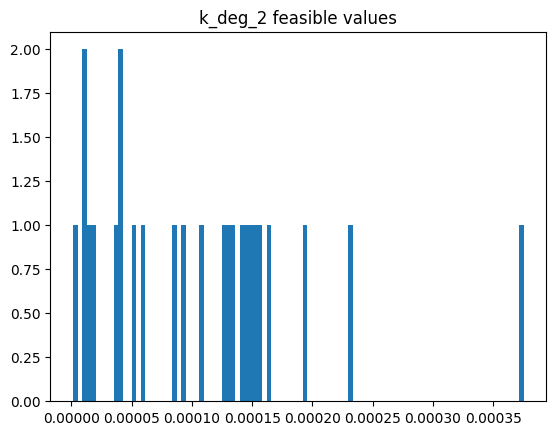

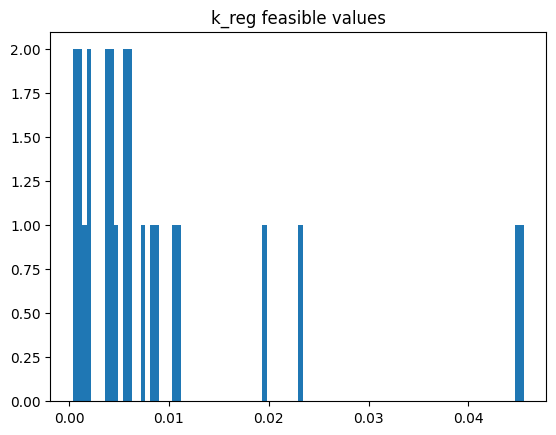

In [186]:
dataset = dataset_counts
confidence = 0.50
d = 3
fixed = [(0, 1)]
K = None

# bootstrap
dataset.confidence = confidence
dataset.bootstrap(d, tqdm_disable=False)

# Interacting birth death
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed, K=K)
opt_BD.analyse_dataset()

rate_names = ['k_tx_1', 'k_deg_1', 'k_tx_2', 'k_deg_2', 'k_reg']
feasible_rates_tx_1 = np.empty((5, 100))
for i in range(100):
    if opt_BD.result_dict[i]['status'] == "OPTIMAL":
        feasible_point = opt_BD.feasible_values_dict[i][-1]
        for r in range(5):
            feasible_rates_tx_1[r, i] = feasible_point[f'k[{r}]']
    else:
        feasible_rates_tx_1[:, i] = None

for r, rate in enumerate(rate_names):
    vals = feasible_rates_tx_1[r, :]
    plt.hist(vals, bins=100);
    plt.title(f"{rate} feasible values")
    plt.show()